In [36]:
import os
import json
import ast
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, filtfilt

In [2]:
def get_cfg_files(base_path):
    cfg_dict = {}

    # Traverse the base directory
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            cfg_files = []
            pat_info_path = None

            # Traverse files in the folder
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".cfg"):
                    file_path = os.path.join(folder_path, file_name)
                    if file_name == "PatInfo.cfg":
                        pat_info_path = file_path
                    else:
                        cfg_files.append(file_path)

            # Add to dictionary if any .cfg files are found
            if pat_info_path or cfg_files:
                cfg_dict[folder_name] = {"patient_info": pat_info_path, "patient_data": cfg_files}

    return cfg_dict

In [3]:
test_dict = get_cfg_files("NewSavedData")
print(test_dict["FC_Astana_4"])

{'patient_info': 'NewSavedData\\FC_Astana_4\\PatInfo.cfg', 'patient_data': ['NewSavedData\\FC_Astana_4\\2025-07-03T14_14_10.cfg', 'NewSavedData\\FC_Astana_4\\2025-07-03T14_22_39.cfg', 'NewSavedData\\FC_Astana_4\\2025-07-03T14_28_03.cfg']}


In [4]:
def process_cfg_file(cfg_path):
    """Process a CFG file and extract the GlobalArray data"""
    try:
        with open(cfg_path, 'r', encoding='utf-8') as f:
            cfg_content = f.read()
    except Exception as e:
        print(f"Error reading file {cfg_path}: {e}")
        return None

    # Extract the GlobalArray data

    # Split the string into Info and GlobalArray parts
    info_part = cfg_content.split("Info=")[1].split("GlobalArray=")[0].strip()
    global_array_part = "[" + cfg_content.split("GlobalArray=[")[1]

    # Convert to Python dictionaries
    info = json.loads(info_part)
    global_array = json.loads(global_array_part)

    # Now you have two Python dictionaries
    if global_array is None:
        print("Failed to extract GlobalArray data")
        return None

    return info, global_array

In [5]:
cfg_path = Path(test_dict["FC_Astana_4"]["patient_data"][2])  # Correctly access the first CFG file path
if not cfg_path.exists():
    print(f"Error: File not found - {cfg_path}")
else:
    print(f"Processing {cfg_path}...")
    info, data = process_cfg_file(cfg_path)

    if data:
        print("\nSuccessfully extracted data:")
        print(json.dumps(data, indent=2))

Processing NewSavedData\FC_Astana_4\2025-07-03T14_28_03.cfg...

Successfully extracted data:
[
  {
    "Name": "ESP32_Sensor_1",
    "Sensor_1": 528,
    "Sensor_2": 0,
    "Sensor_3": 182,
    "Sensor_4": 0,
    "Time": "2172281",
    "XData": 319,
    "YData": -1,
    "ZData": -6
  },
  {
    "Name": "ESP32_Sensor_2",
    "Sensor_1": 335,
    "Sensor_2": 0,
    "Sensor_3": 0,
    "Sensor_4": 0,
    "Time": "2172281",
    "XData": 165,
    "YData": -15,
    "ZData": 12
  },
  {
    "Name": "ESP32_Sensor_1",
    "Sensor_1": 359,
    "Sensor_2": 0,
    "Sensor_3": 162,
    "Sensor_4": 70,
    "Time": "2172329",
    "XData": 319,
    "YData": -1,
    "ZData": -6
  },
  {
    "Name": "ESP32_Sensor_1",
    "Sensor_1": 373,
    "Sensor_2": 0,
    "Sensor_3": 97,
    "Sensor_4": 23,
    "Time": "2172396",
    "XData": 320,
    "YData": 1,
    "ZData": -10
  },
  {
    "Name": "ESP32_Sensor_2",
    "Sensor_1": 406,
    "Sensor_2": 0,
    "Sensor_3": 0,
    "Sensor_4": 0,
    "Time": "2172396"

In [6]:
def lowpass_filter(data, cutoff=5, fs=100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def get_segmens(times, data, plateau_groups, sensor_name="Test", min_length=10):
    plt.figure(figsize=(12, 6))
    plt.plot(times, data, 'b-', linewidth=1, label='Filtered Data')
    segments = []
    for i, group in enumerate(plateau_groups):
        if len(group) >= min_length:
            start, end = group[0], group[-1] + 1  # +1 because we used diff earlier
            segments.append((times[start], times[end]))
            plt.plot(times[start:end+1], data[start:end+1],
                    'r-', linewidth=2, label='Plateau' if i == 0 else None)

    plt.title(f'{sensor_name}: Data with Plateau Regions)')
    plt.xlabel('Relative Time (ms)')
    plt.ylabel('Angle (degrees)')
    plt.grid(True)
    plt.legend()
    plt.show()
    return segments

def process_sensor_data(sensor_data, cutoff_frequency=10):
    # Extract time and XData values
    times = [int(data["Time"]) for data in sensor_data]
    x_data = [data["XData"] for data in sensor_data]

    # Convert angles to radians, unwrap, then back to degrees
    x_data = np.rad2deg(np.unwrap(np.deg2rad(x_data)))

    # Apply lowpass filter
    filtered_x_data = lowpass_filter(x_data, cutoff=cutoff_frequency)

    # Calculate relative time
    relative_times = [t - times[0] for t in times]

    return relative_times, filtered_x_data

def process_all_data(sensor_data_1, cutoff_frequency=10):
    times_1 = [int(data["Time"]) for data in sensor_data_1]
    z_data_1 = [data["XData"] for data in sensor_data_1]
    y_data_1 = [data["YData"] for data in sensor_data_1]
    x_data_1 = [data["ZData"] for data in sensor_data_1]

    sensor_1_1 = [data["Sensor_1"] for data in sensor_data_1]
    sensor_2_1 = [data["Sensor_2"] for data in sensor_data_1]
    sensor_3_1 = [data["Sensor_3"] for data in sensor_data_1]
    sensor_4_1 = [data["Sensor_4"] for data in sensor_data_1]

    # Convert angles to radians, unwrap, then back to degrees
    z_data_1 = np.rad2deg(np.unwrap(np.deg2rad(z_data_1)))
    y_data_1 = np.rad2deg(np.unwrap(np.deg2rad(y_data_1)))
    x_data_1 = np.rad2deg(np.unwrap(np.deg2rad(x_data_1)))

    # Apply lowpass filter
    filtered_z_data_1 = lowpass_filter(z_data_1, cutoff=cutoff_frequency)
    filtered_y_data_1 = lowpass_filter(y_data_1, cutoff=cutoff_frequency)
    filtered_x_data_1 = lowpass_filter(x_data_1, cutoff=cutoff_frequency)


    # Calculate relative time
    relative_times_1 = [t - times_1[0] for t in times_1]

    d = {
        "Time": relative_times_1,
        "X": filtered_x_data_1,
        "Y": filtered_y_data_1,
        "Z": filtered_z_data_1,
        "Sensor_1": sensor_1_1,
        "Sensor_2": sensor_2_1,
        "Sensor_3": sensor_3_1,
        "Sensor_4": sensor_4_1
    }

    df = pd.DataFrame(d)

    return df



def find_plateaus(data, threshold=1.0):
    derivative = np.diff(data)
    plateau_indices = np.where(np.abs(derivative) < threshold)[0]

    plateau_groups = []
    if len(plateau_indices) > 0:
        current_group = [plateau_indices[0]]
        for i in range(1, len(plateau_indices)):
            if plateau_indices[i] == plateau_indices[i-1] + 1:
                current_group.append(plateau_indices[i])
            else:
                plateau_groups.append(current_group)
                current_group = [plateau_indices[i]]
        plateau_groups.append(current_group)

    return plateau_groups


def filter_df(df, segments):
    # Create a list of filtered chunks
    filtered_chunks = [df[(df["Time"] >= start) & (df["Time"] <= end)] for start, end in segments]

    # Combine them into one DataFrame
    filtered_df = pd.concat(filtered_chunks, ignore_index=True)

    return filtered_df

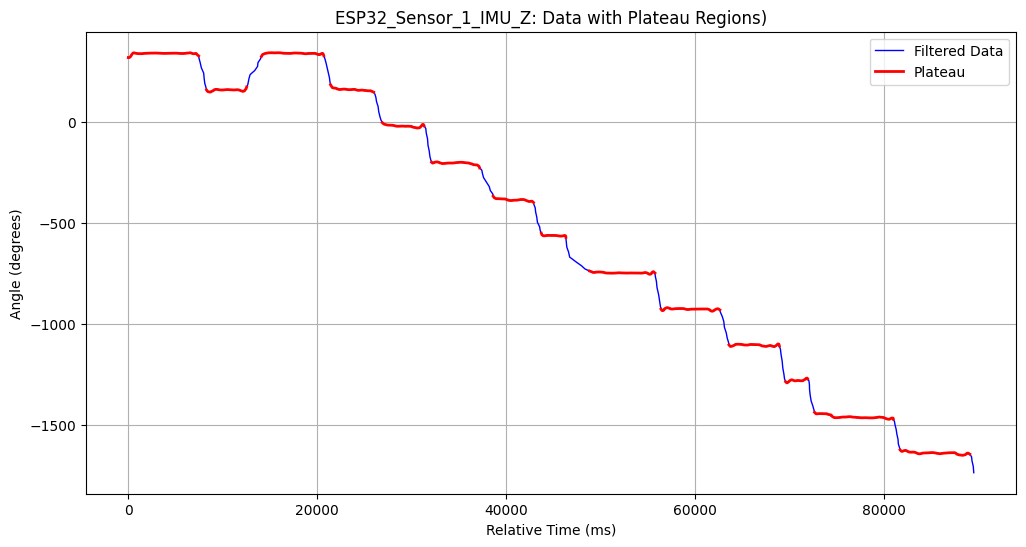

In [7]:
# Get sensor_data
sensor_data = [entry for entry in data if entry['Name'] == "ESP32_Sensor_1"]
sensor_data_2 = [entry for entry in data if entry['Name'] == "ESP32_Sensor_2"]

if not sensor_data:
    print("No data found for ESP32_Sensor_1")
else:
    relative_times, filtered_x_data = process_sensor_data(sensor_data)
    plateau_groups = find_plateaus(filtered_x_data, threshold=10)
    segments = get_segmens(relative_times, filtered_x_data, plateau_groups, sensor_name="ESP32_Sensor_1_IMU_Z")

In [8]:
print(segments)

[(0, 7447), (8281, 12531), (14098, 20698), (21414, 25982), (26881, 31314), (32113, 37198), (38632, 42897), (43729, 46330), (48830, 55762), (56396, 62630), (63597, 68929), (69596, 71929), (72662, 80996), (81712, 89096)]


In [ ]:
def convert_to_pickle(name_of_file):
    test_dict = get_cfg_files("NewSavedData")
    cfg_path = test_dict[name_of_file]  # Correctly access the first CFG file path

    with open(cfg_path['patient_info'], 'r', encoding='utf-8') as f:
        patient_info = f.read()

    dict_str = patient_info.split("=", 1)[1].strip()

    # Convert to a Python dictionary using ast.literal_eval
    info_dict = ast.literal_eval(dict_str)

    if not os.path.exists(f"processed_data/{name_of_file}"):
        os.makedirs(f"processed_data/{name_of_file}")
    

    with open(f"processed_data/{name_of_file}/{name_of_file}_info.txt", "w") as f:
        f.write(json.dumps(info_dict, indent=2))

    index_of_trial = 1

    for trial in cfg_path['patient_data']:
        trial = Path(trial)
        if not trial.exists():
            print(f"Error: File not found - {cfg_path}")
        else:
            # print(trial)
            print(f"Processing {trial}...")
            info, data = process_cfg_file(trial)

            if data:
                print("\nSuccessfully extracted data:")
            else:
                print("Failed to extract data.")
                continue
            
            sensor_data_1 = [entry for entry in data if entry['Name'] == "ESP32_Sensor_1"]
            sensor_data_2 = [entry for entry in data if entry['Name'] == "ESP32_Sensor_2"]

            df_1 = process_all_data(sensor_data_1)
            df_2 = process_all_data(sensor_data_2)

            relative_times, filtered_x_data = process_sensor_data(sensor_data_1)
            plateau_groups = find_plateaus(filtered_x_data, threshold=10)
            segments_1 = get_segmens(relative_times, filtered_x_data, plateau_groups, sensor_name="ESP32_Sensor_1_IMU_Z")

            filtered_df_1 = filter_df(df_1, segments_1)

            relative_times_2, filtered_x_data_2 = process_sensor_data(sensor_data_2)
            plateau_groups_2 = find_plateaus(filtered_x_data_2, threshold=10)
            segments_2 = get_segmens(relative_times_2, filtered_x_data_2, plateau_groups_2, sensor_name="ESP32_Sensor_2_IMU_Z")

            filtered_df_2 = filter_df(df_2, segments_2)
            sequence1 = filtered_df_1[['Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4']].to_numpy()
            sequence2 = filtered_df_2[['Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4']].to_numpy()

            all_sequences = [sequence1, sequence2]  # up to 20
            output_file = f"processed_data/{name_of_file}/{name_of_file}_trial_{index_of_trial}.pkl"

            with open(output_file, "wb") as f:
                pickle.dump(all_sequences, f)

            index_of_trial += 1

# convert_to_pickle("FC_Astana_4")

In [51]:
patients = ['FC_Astana_4', 'FC_Astana_5', 'FC_Astana_6', "InMotio_Kyz", 'InMotion_1407', "InMotion_Kai", "InMotion_Mir", "InMotion_Nur", "Mamyr_1", "Mamyr_2", "Mamyr_3", "Mamyr_4", "Mamyr_5", "Mamyr_6", "Mamyr_7", "Mamyr_8", "Mamyr_9", "Mamyr_10", "Mamyr_11", "Prothesis_1", "Roman_Olimp_Chemp"]

Processing NewSavedData\FC_Astana_4\2025-07-03T14_14_10.cfg...

Successfully extracted data:


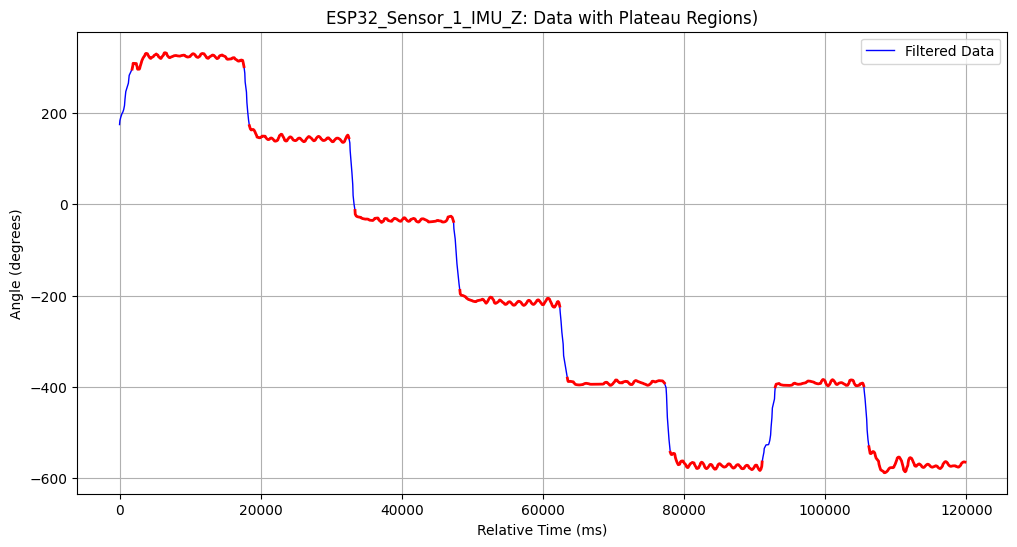

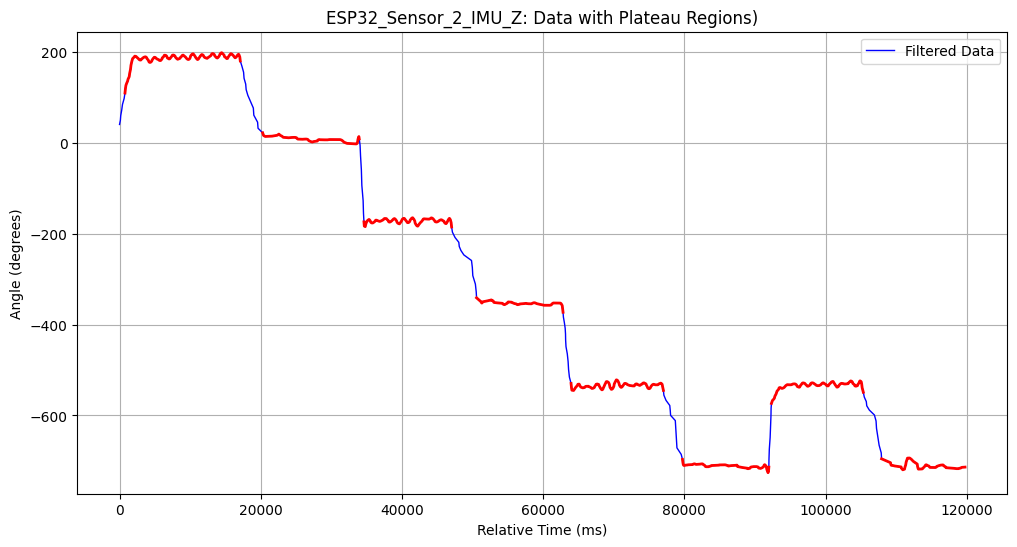

Processing NewSavedData\FC_Astana_4\2025-07-03T14_22_39.cfg...

Successfully extracted data:


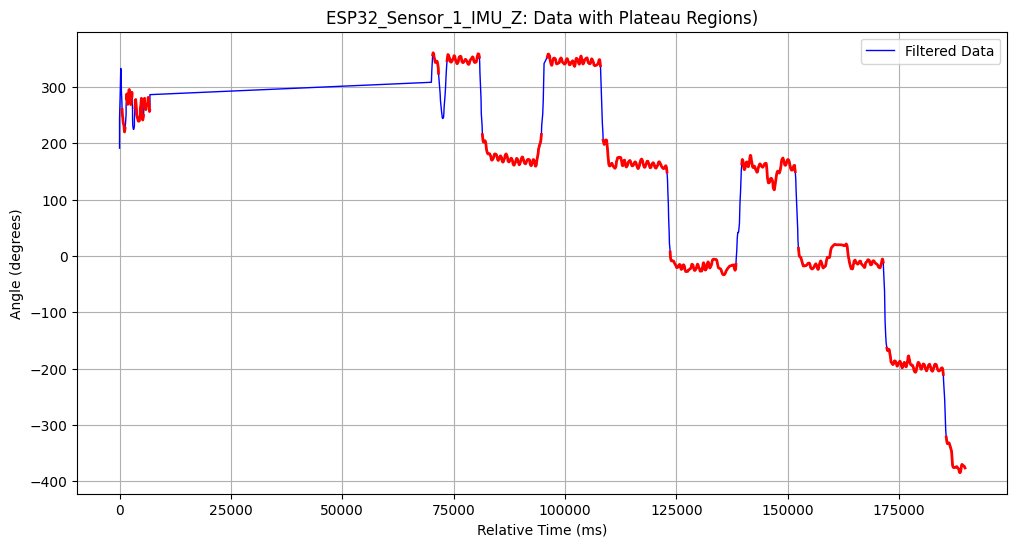

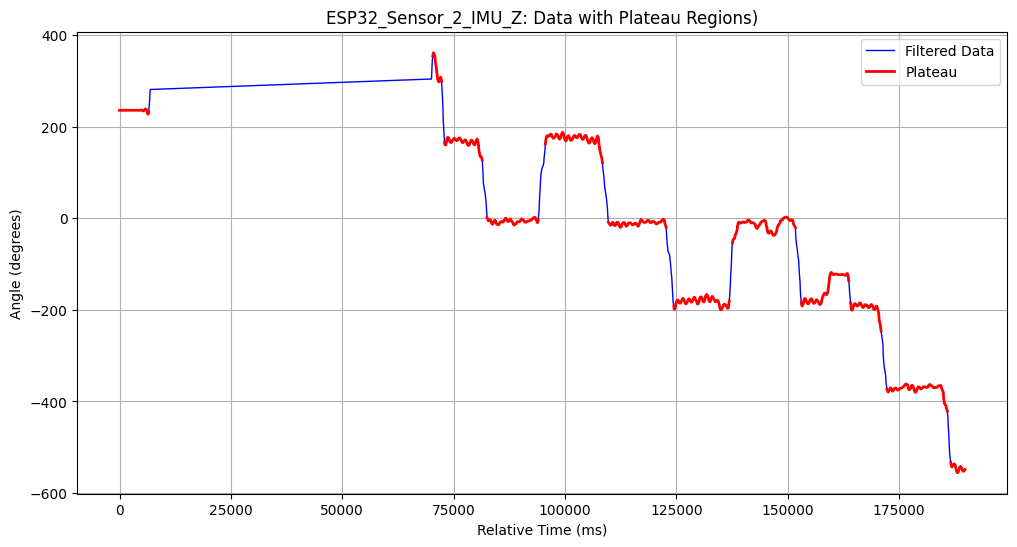

Processing NewSavedData\FC_Astana_4\2025-07-03T14_28_03.cfg...

Successfully extracted data:


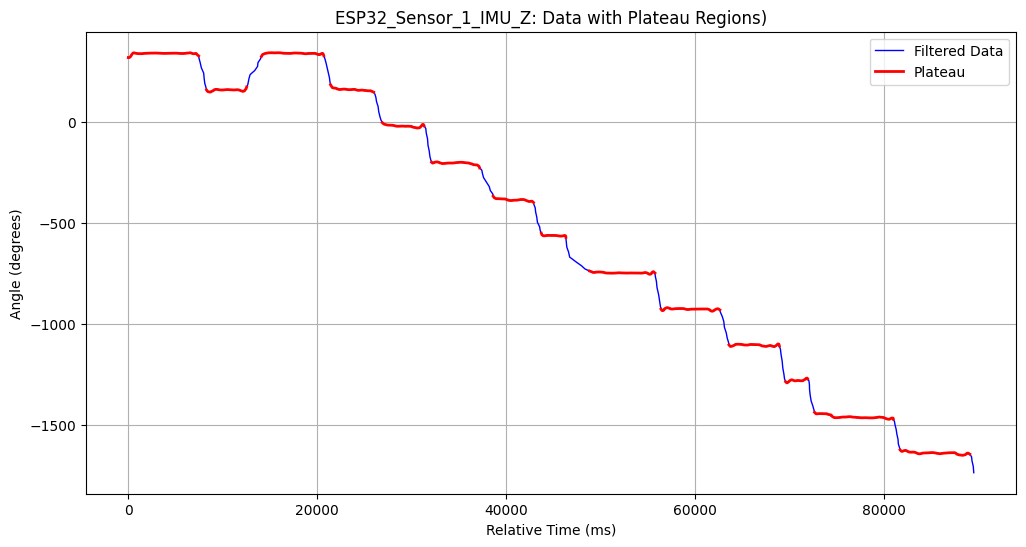

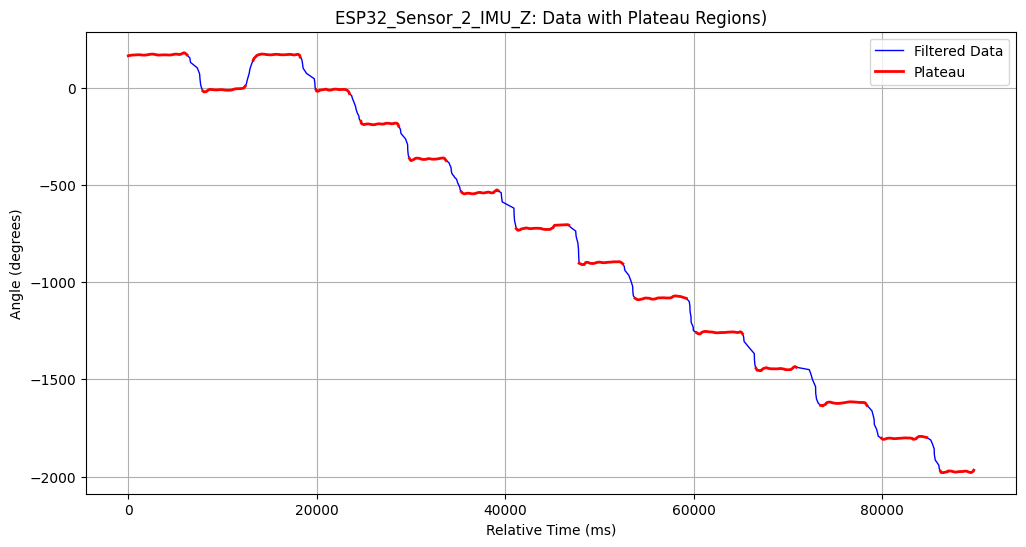

Processed FC_Astana_4 successfully.
Processing NewSavedData\FC_Astana_5\2025-07-05T09_51_22.cfg...

Successfully extracted data:


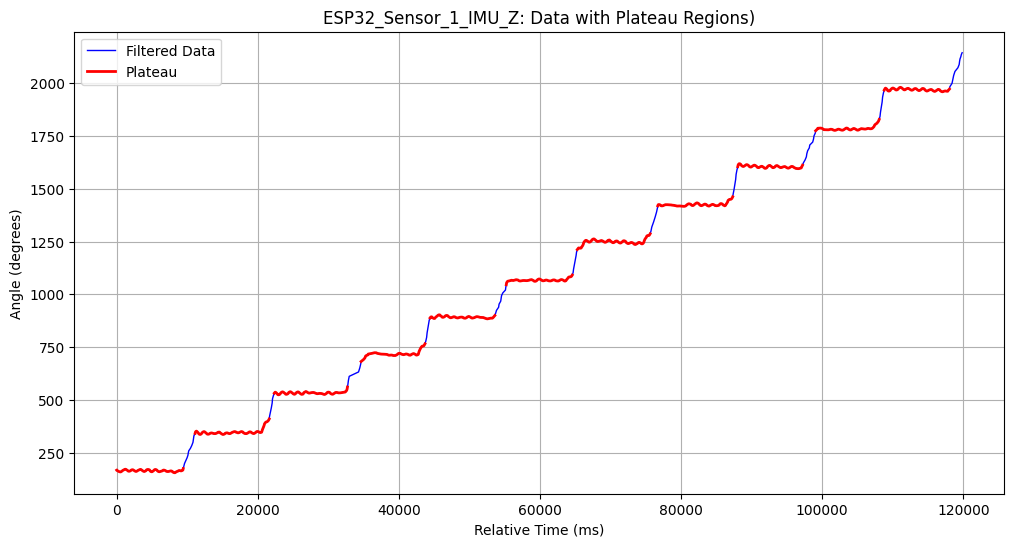

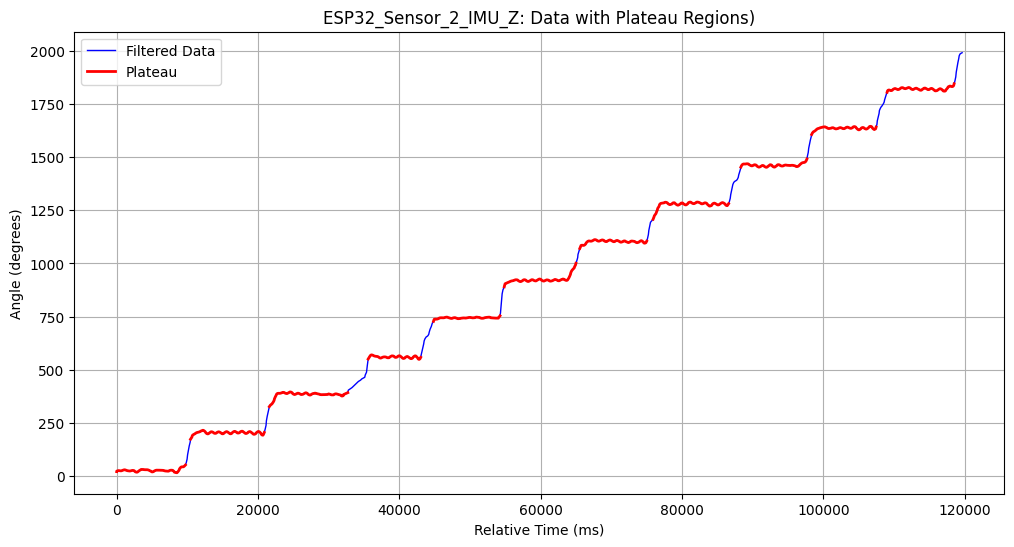

Processing NewSavedData\FC_Astana_5\2025-07-05T09_56_02.cfg...

Successfully extracted data:


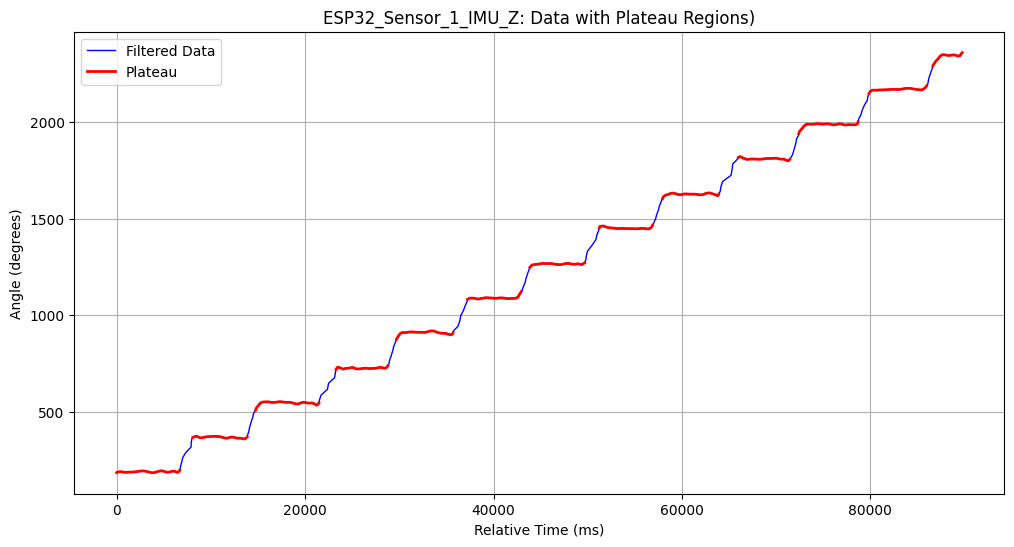

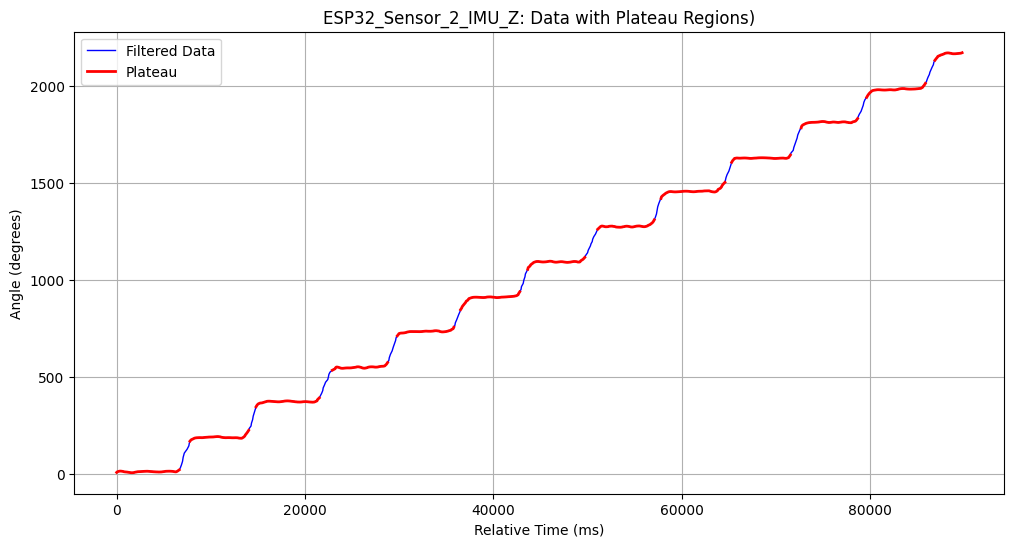

Processing NewSavedData\FC_Astana_5\2025-07-05T10_02_35.cfg...

Successfully extracted data:


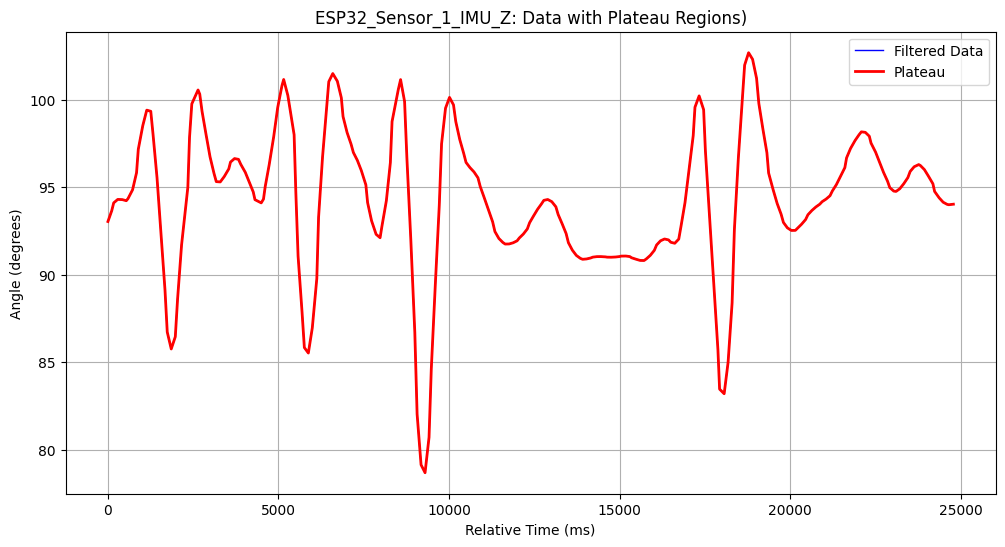

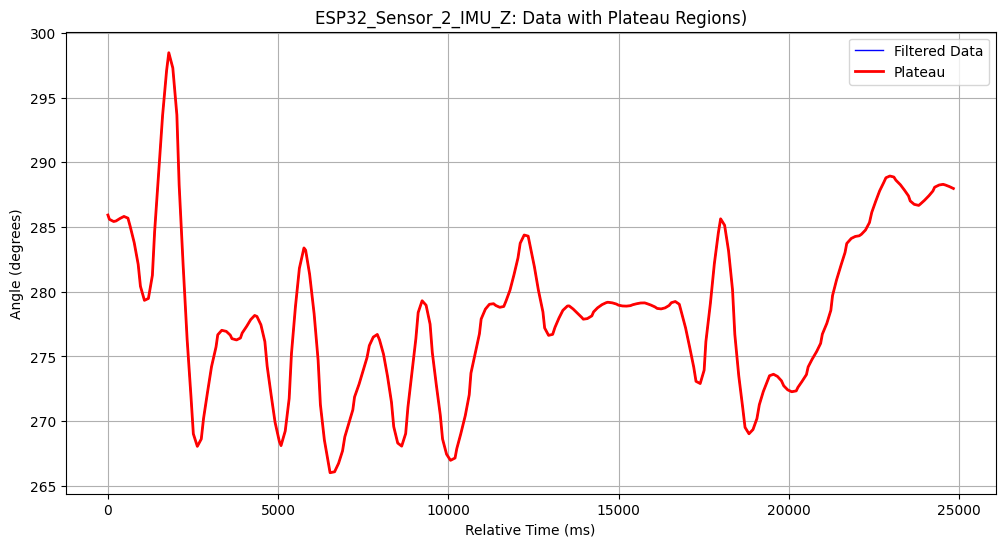

Processing NewSavedData\FC_Astana_5\2025-07-05T10_04_53.cfg...

Successfully extracted data:


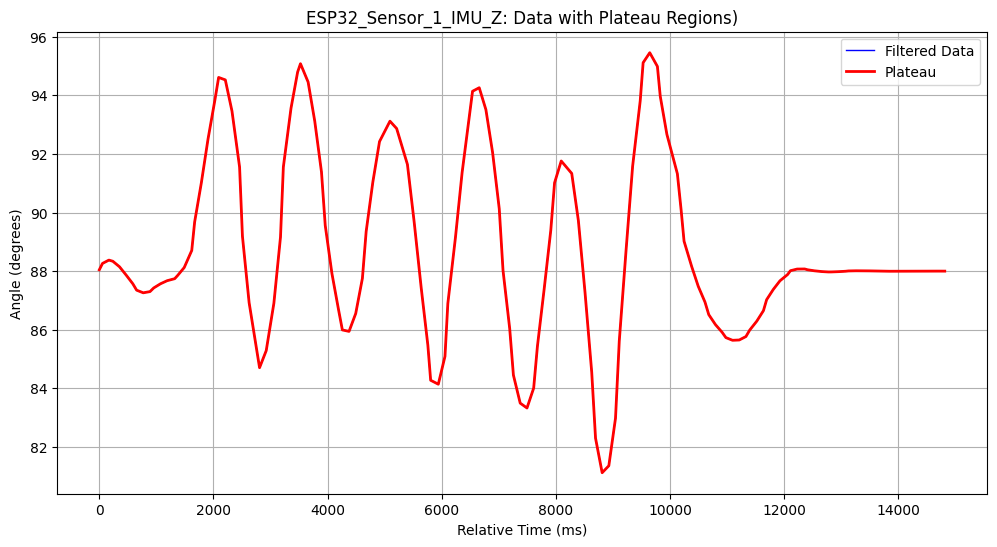

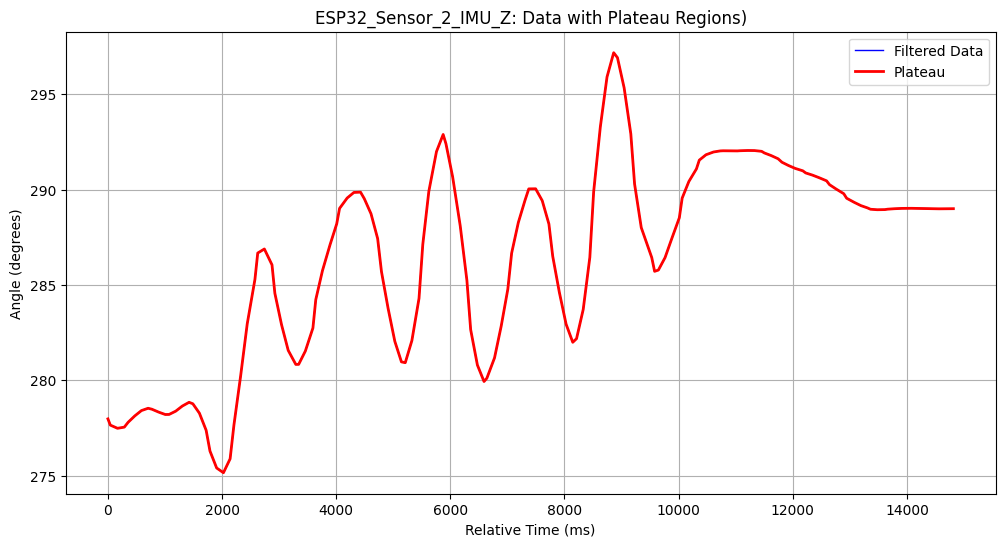

Processing NewSavedData\FC_Astana_5\2025-07-05T10_06_27.cfg...

Successfully extracted data:


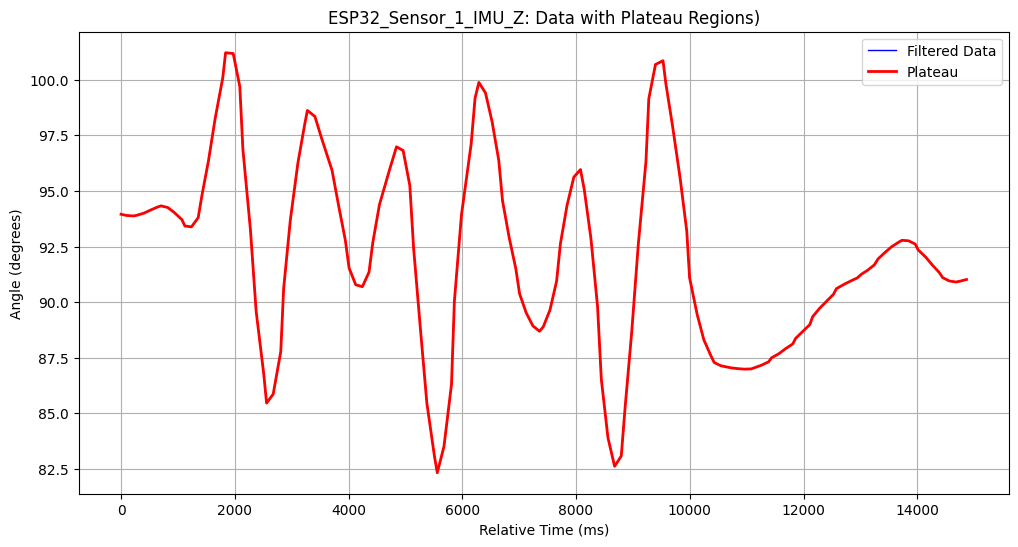

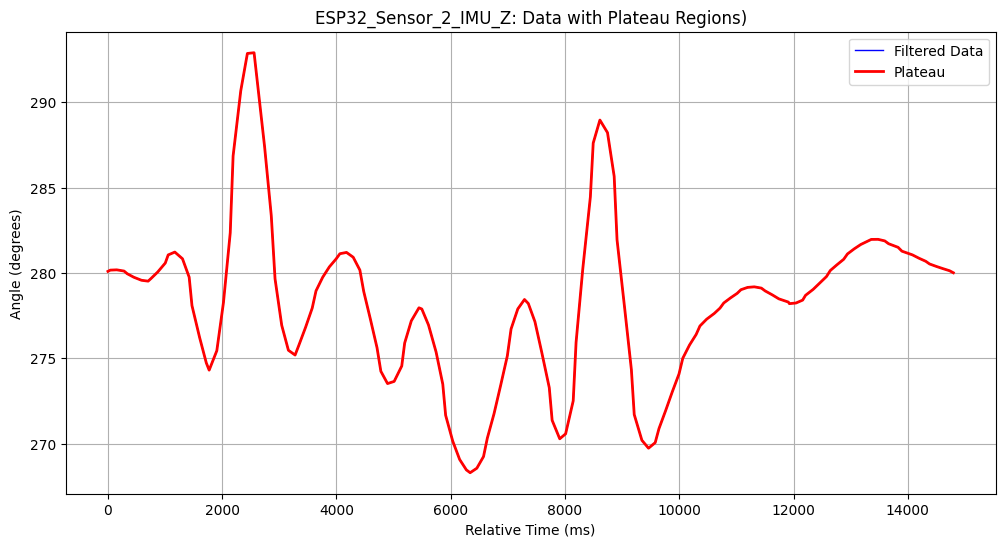

Processed FC_Astana_5 successfully.
Processing NewSavedData\FC_Astana_6\2025-07-05T10_17_58.cfg...

Successfully extracted data:


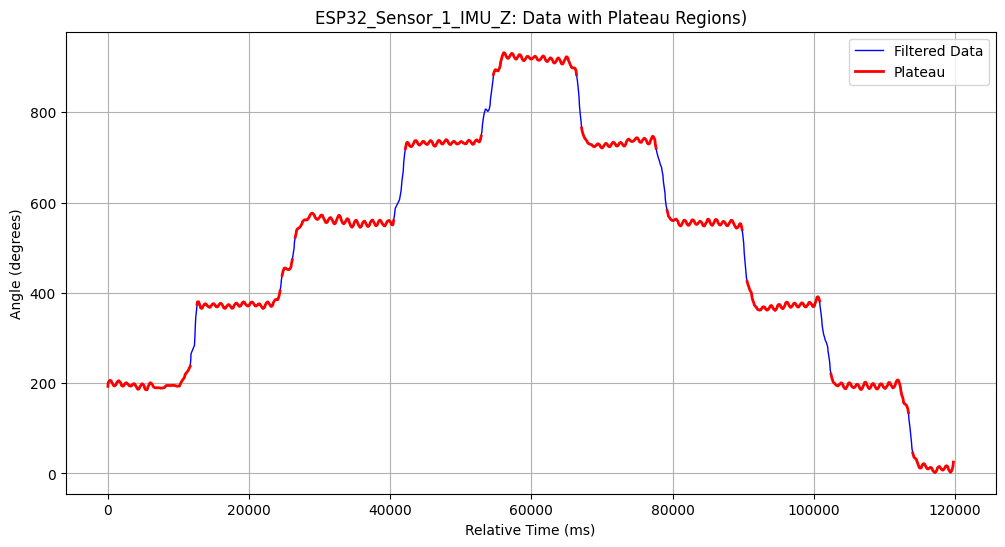

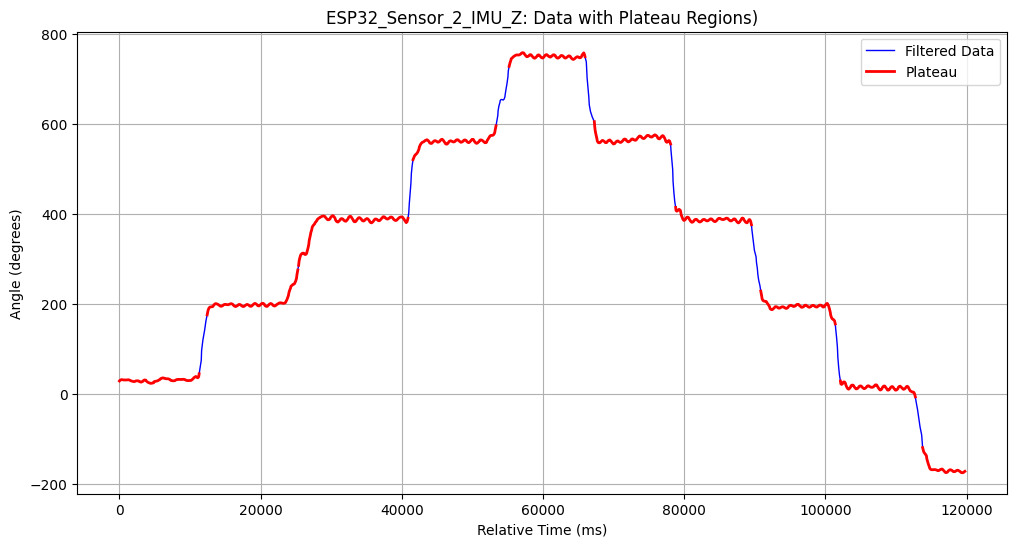

Processing NewSavedData\FC_Astana_6\2025-07-05T10_20_47.cfg...

Successfully extracted data:


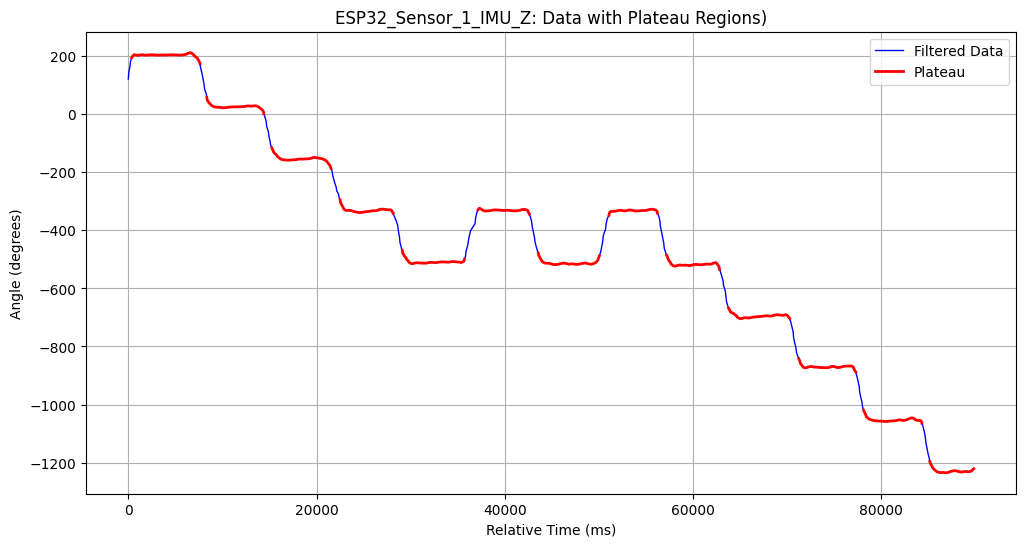

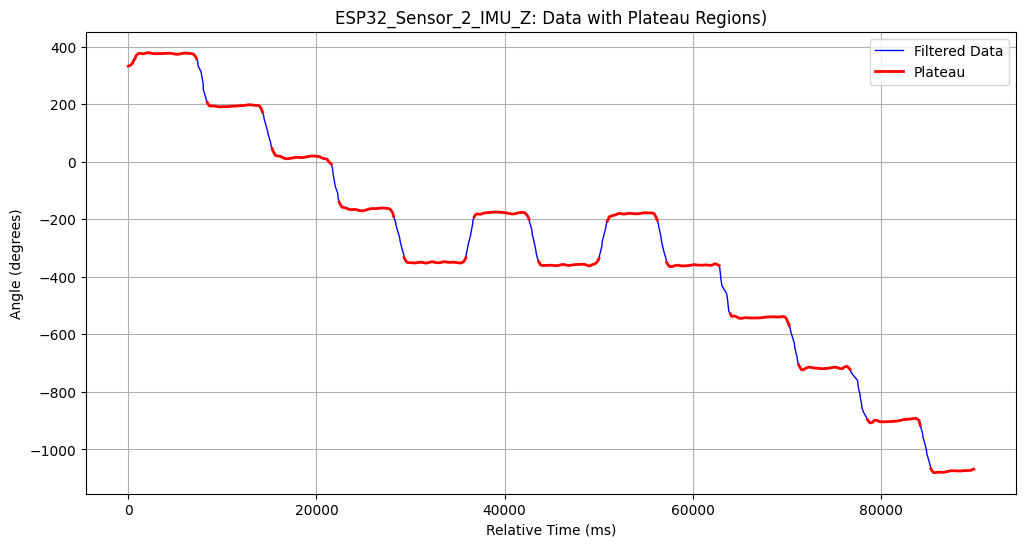

Processing NewSavedData\FC_Astana_6\2025-07-05T10_23_23.cfg...

Successfully extracted data:


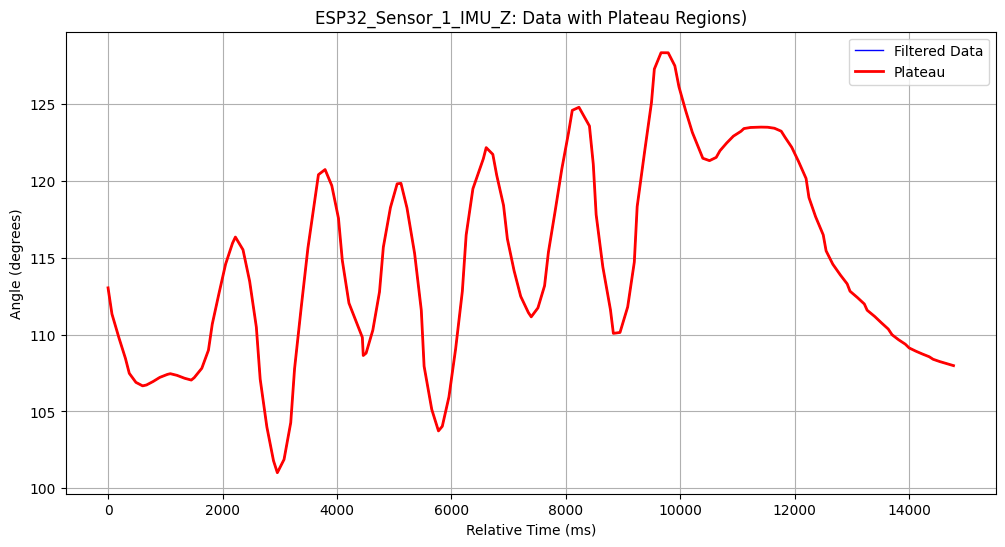

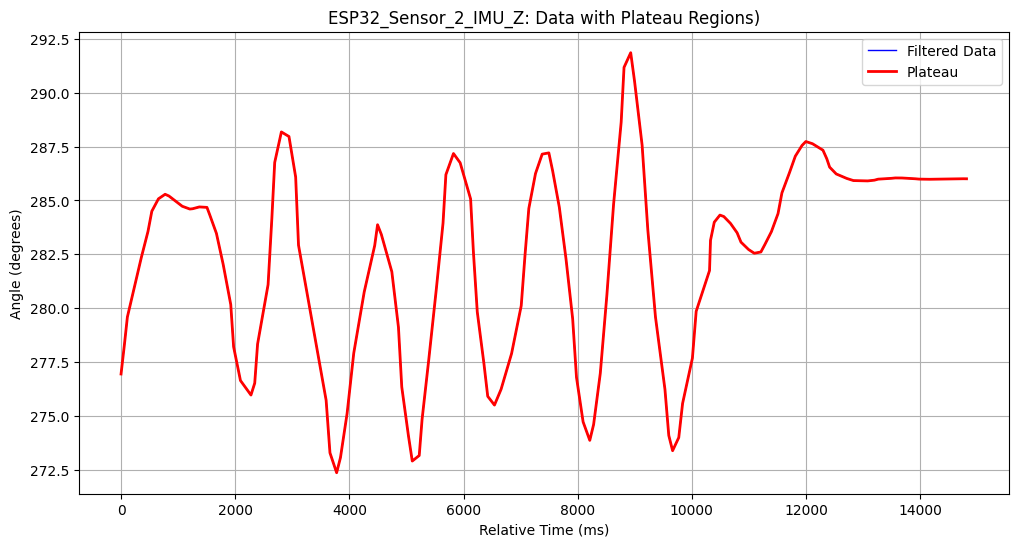

Processing NewSavedData\FC_Astana_6\2025-07-05T10_24_36.cfg...

Successfully extracted data:


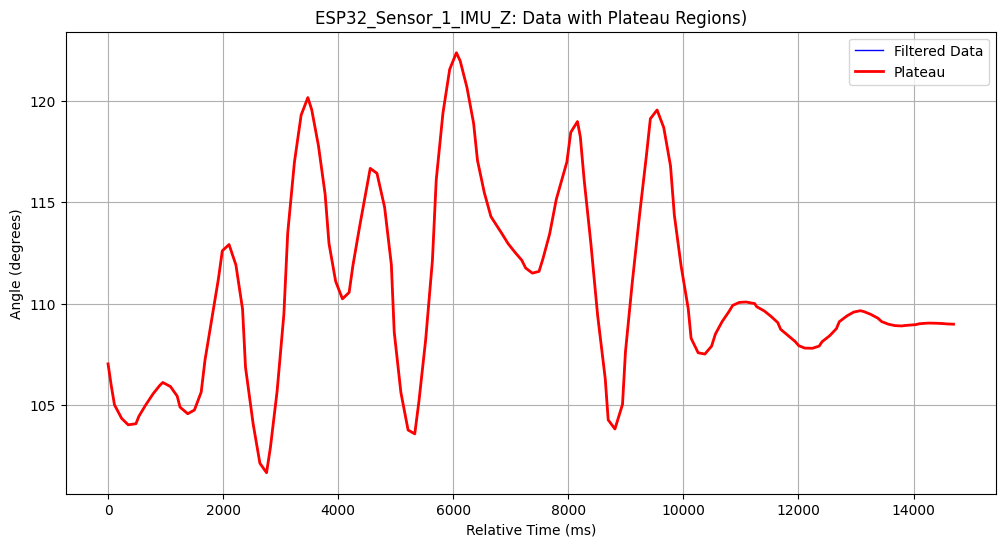

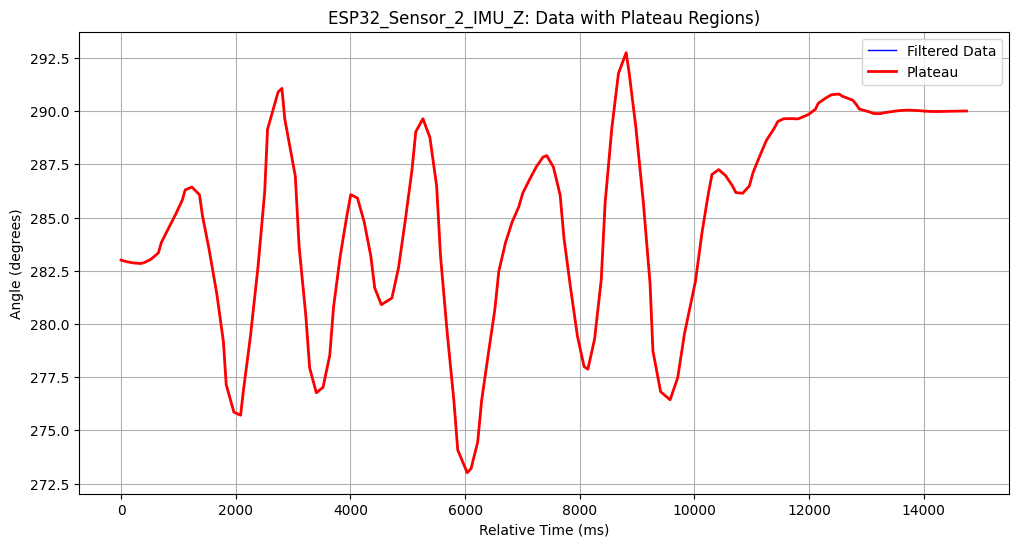

Processed FC_Astana_6 successfully.
Processing NewSavedData\InMotio_Kyz\2025-07-14T10_09_20.cfg...

Successfully extracted data:


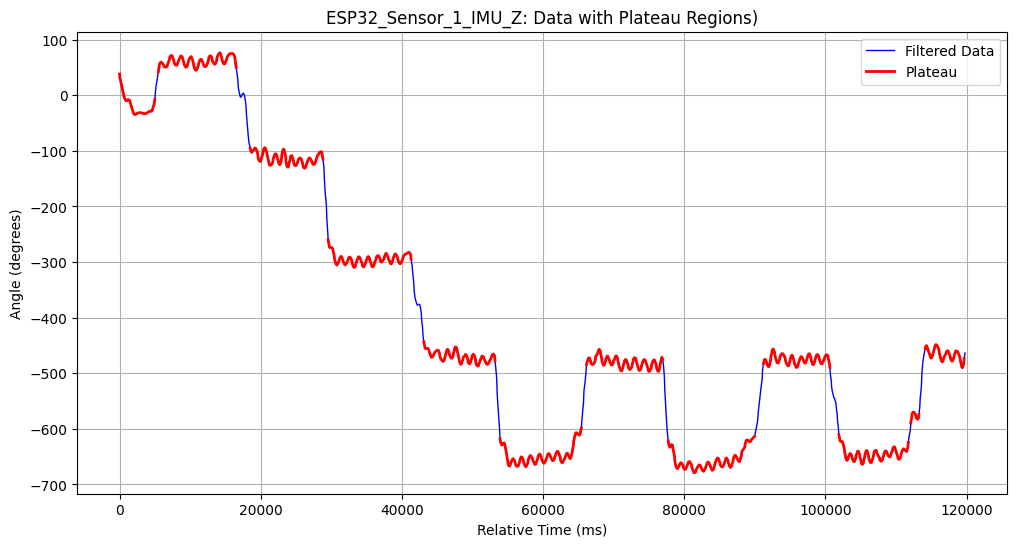

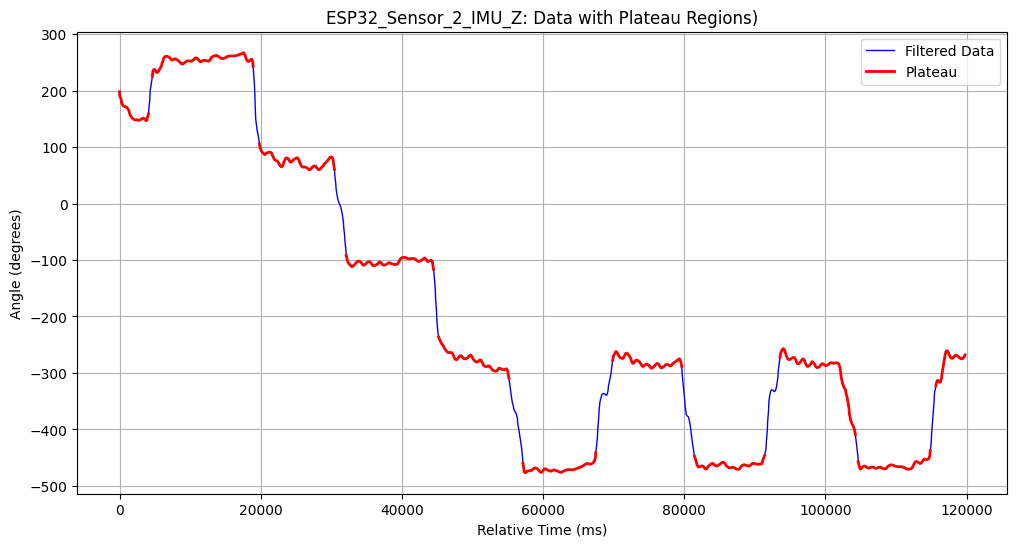

Processing NewSavedData\InMotio_Kyz\2025-07-14T10_47_52.cfg...

Successfully extracted data:


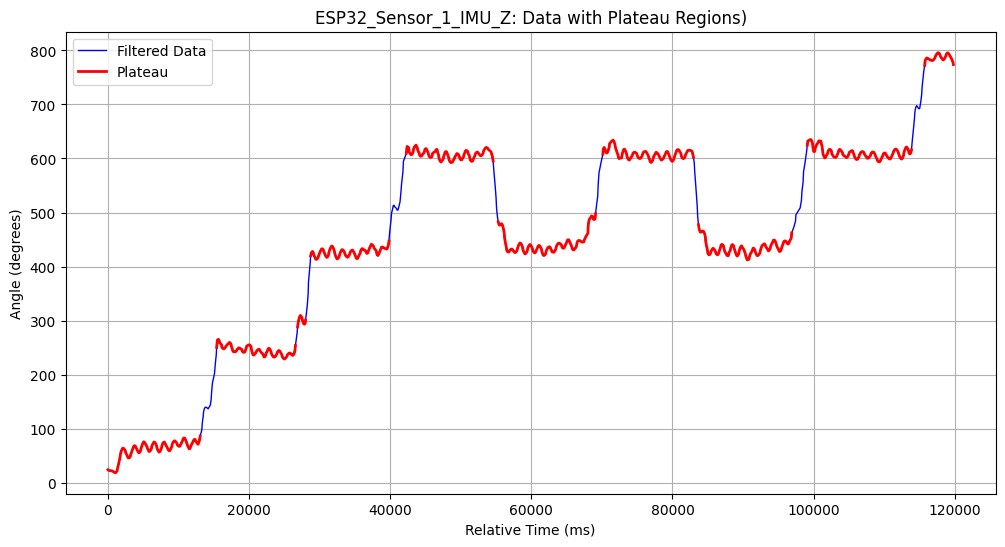

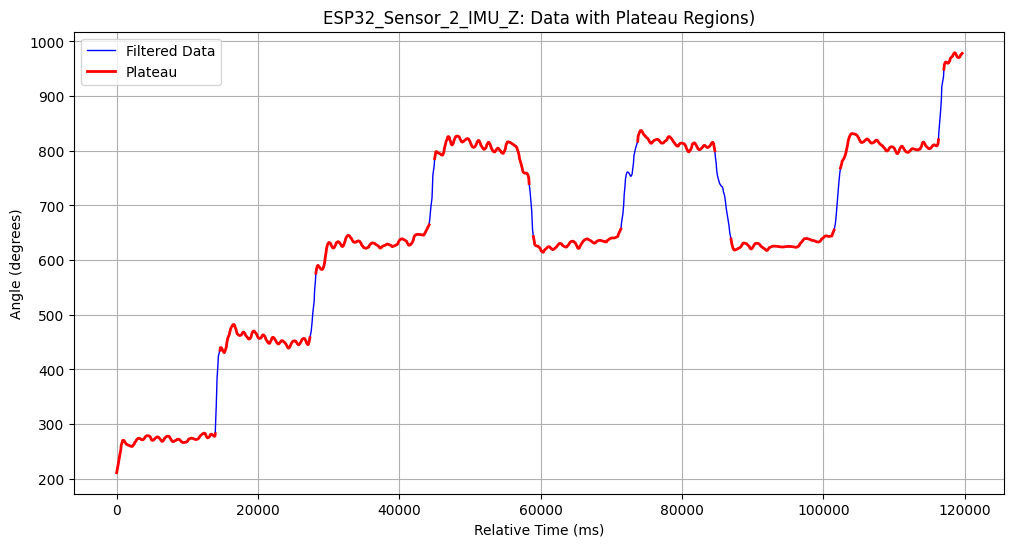

Processed InMotio_Kyz successfully.
Processing NewSavedData\InMotion_1407\2025-07-14T18_14_22.cfg...

Successfully extracted data:


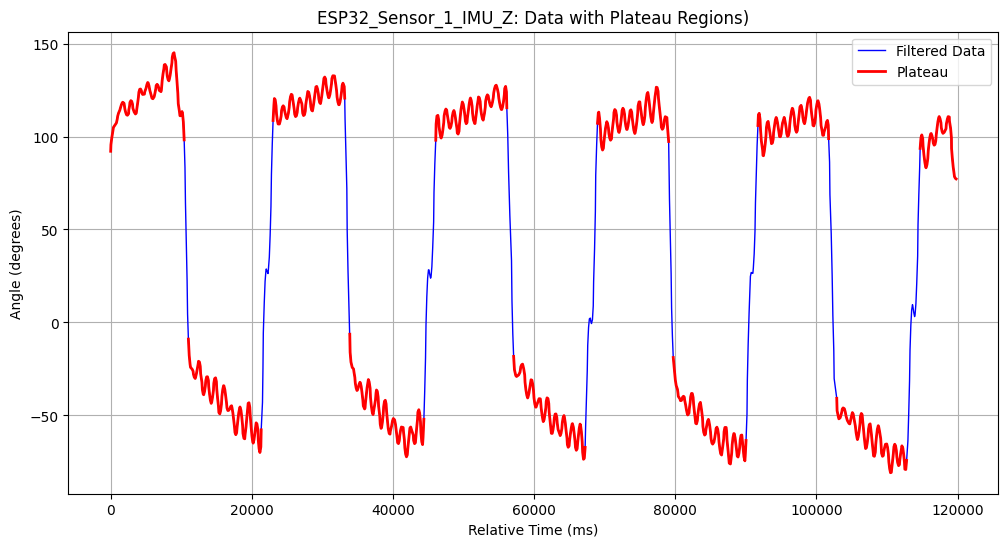

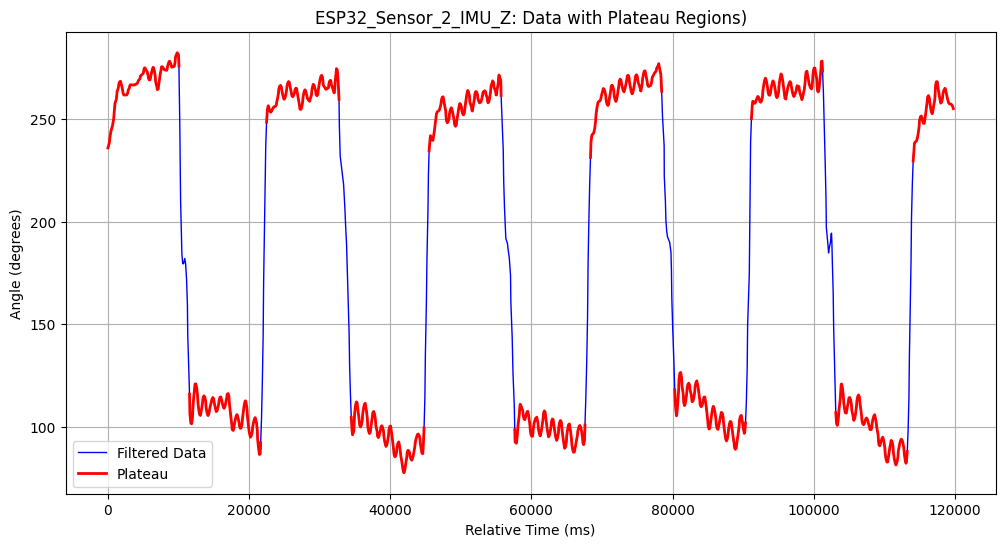

Processed InMotion_1407 successfully.
Processing NewSavedData\InMotion_Kai\2025-07-11T17_10_44.cfg...

Successfully extracted data:


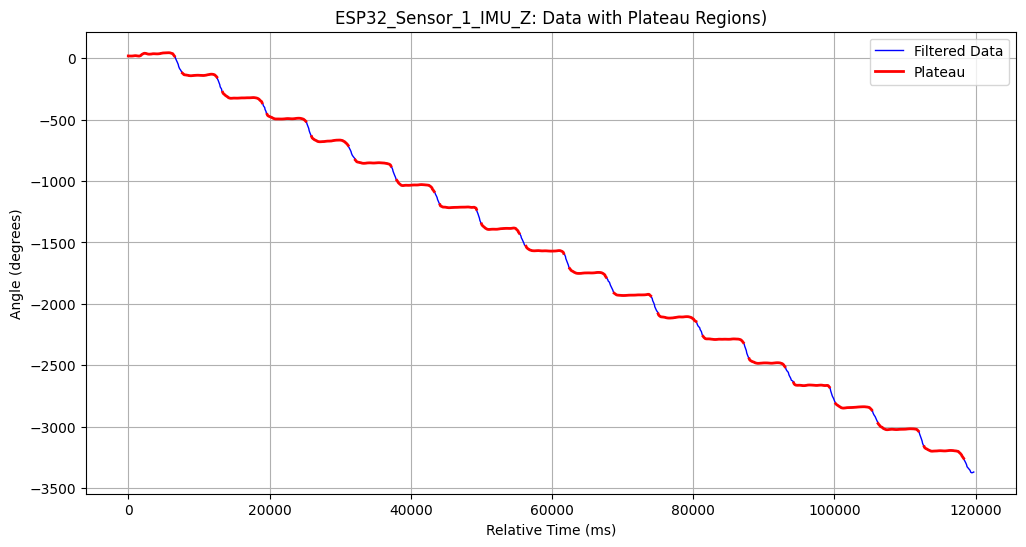

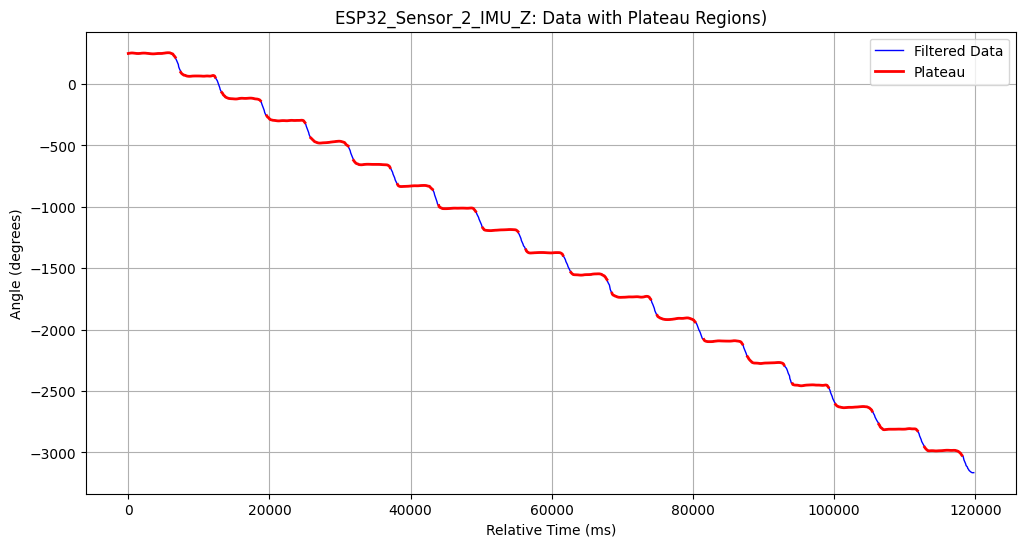

Processed InMotion_Kai successfully.
Processing NewSavedData\InMotion_Mir\2025-07-16T09_38_52.cfg...

Successfully extracted data:


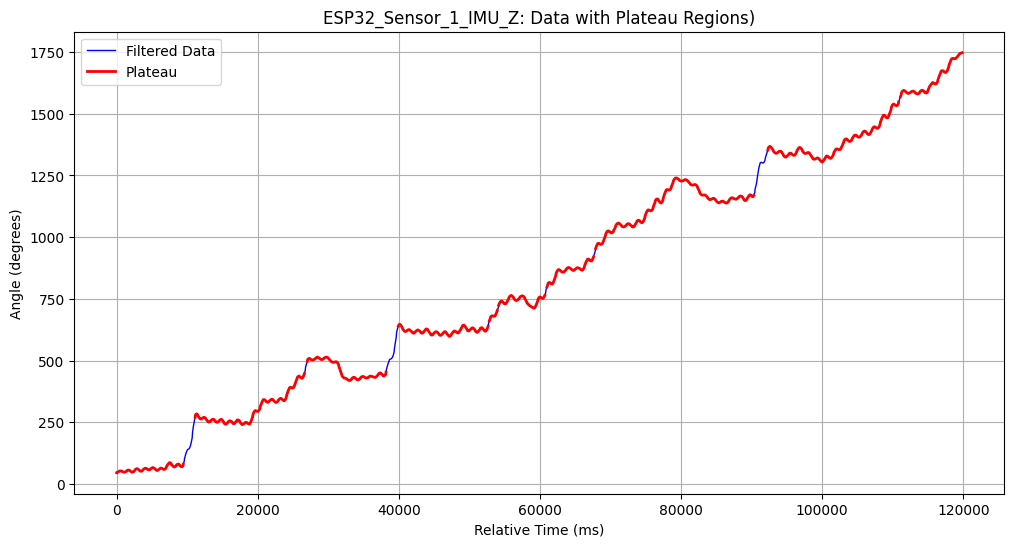

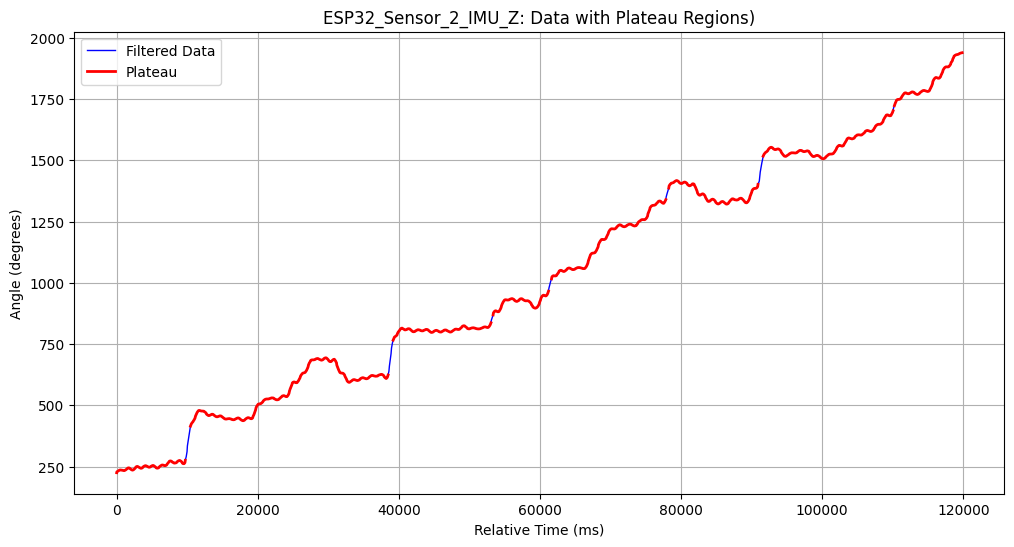

Processing NewSavedData\InMotion_Mir\2025-07-16T09_42_48.cfg...

Successfully extracted data:


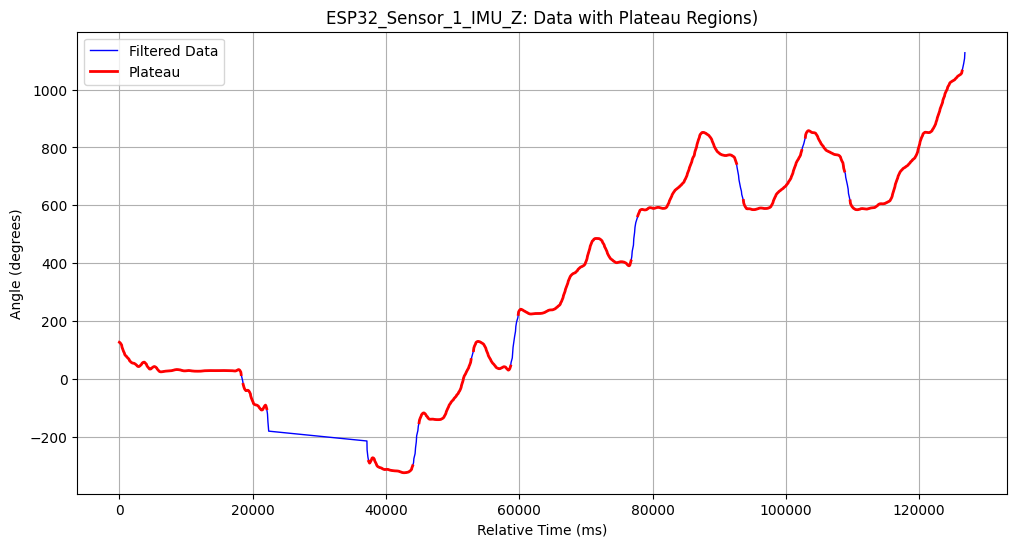

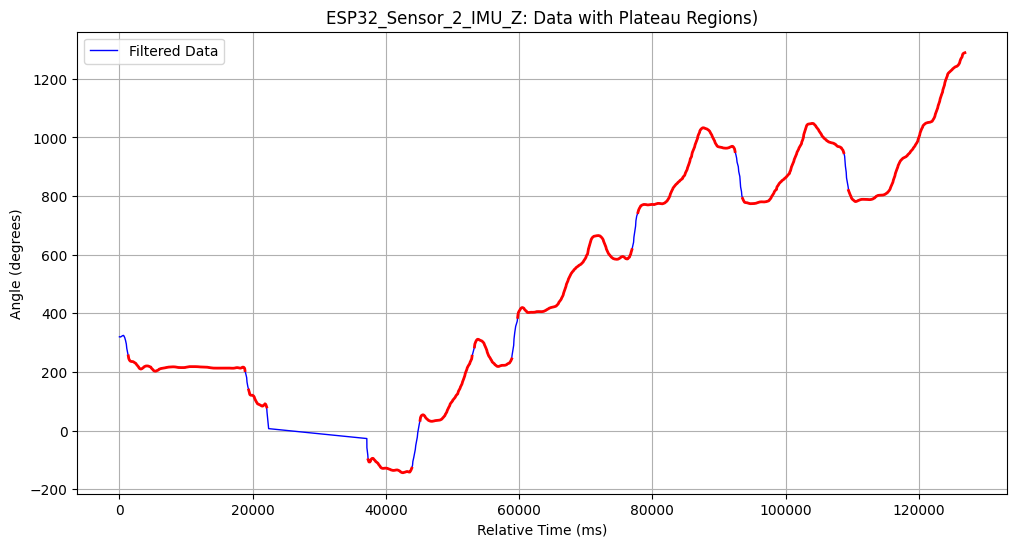

Processed InMotion_Mir successfully.
Processing NewSavedData\InMotion_Nur\2025-07-14T11_33_54.cfg...

Successfully extracted data:


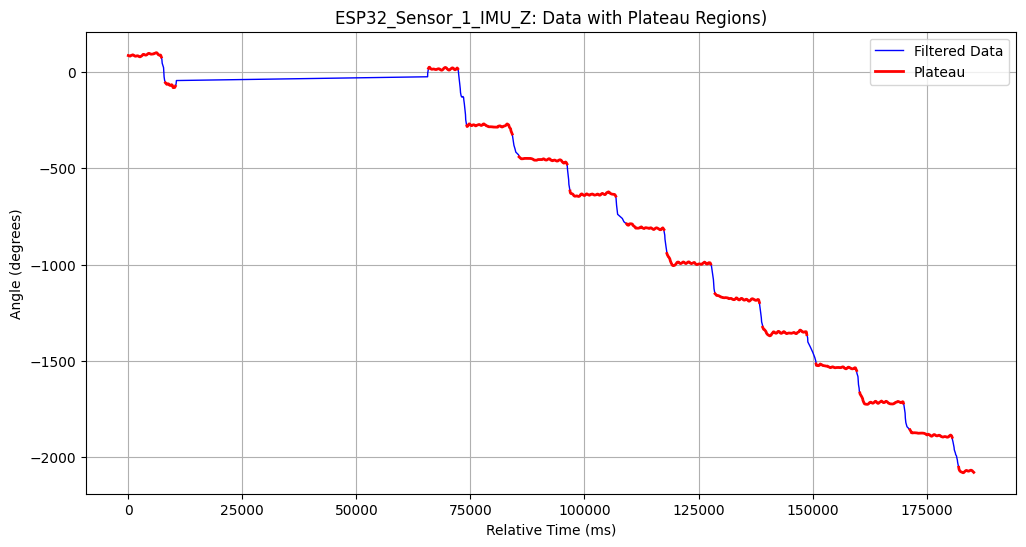

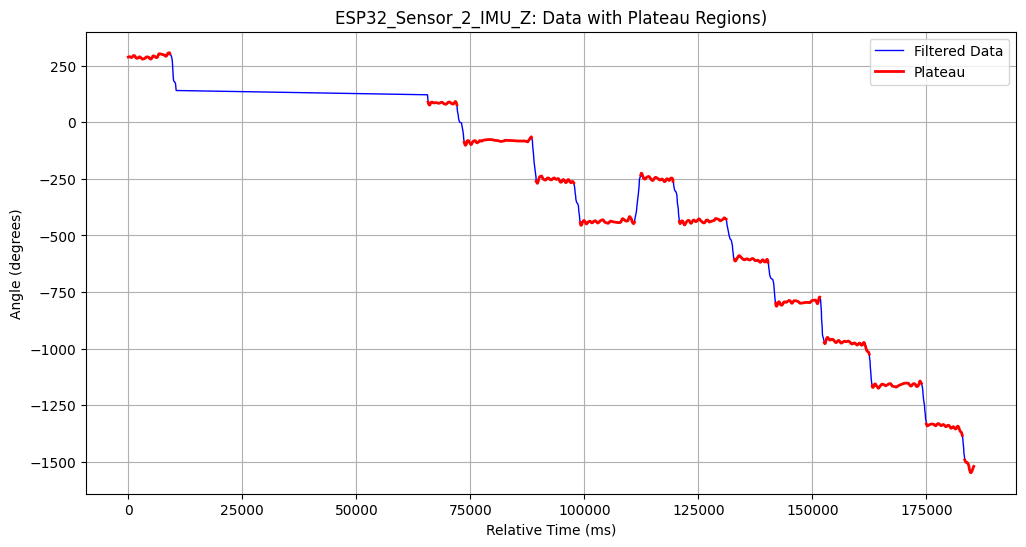

Processed InMotion_Nur successfully.
Processing NewSavedData\Mamyr_1\2025-07-03T10_43_08.cfg...

Successfully extracted data:


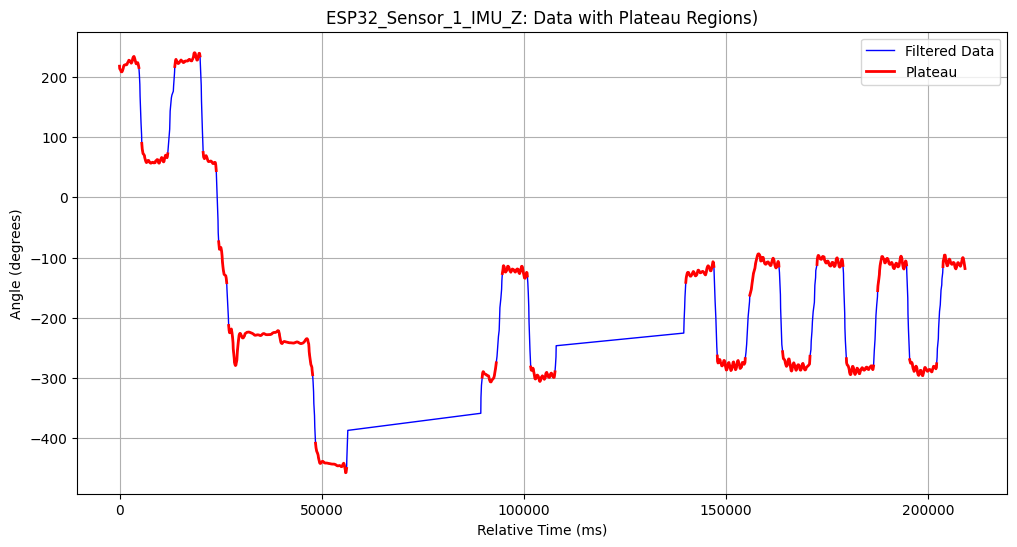

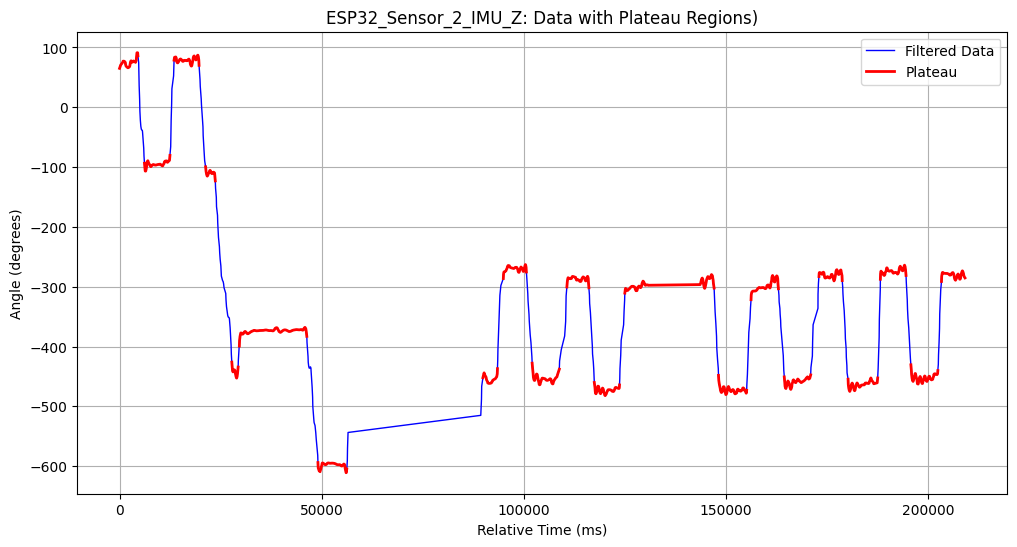

Processed Mamyr_1 successfully.
Processing NewSavedData\Mamyr_2\2025-07-03T11_02_19.cfg...

Successfully extracted data:


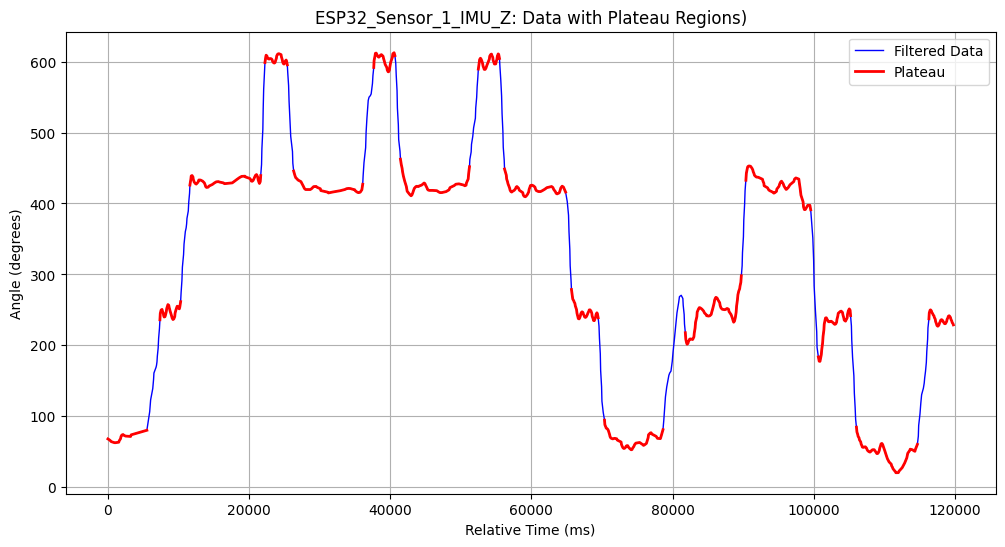

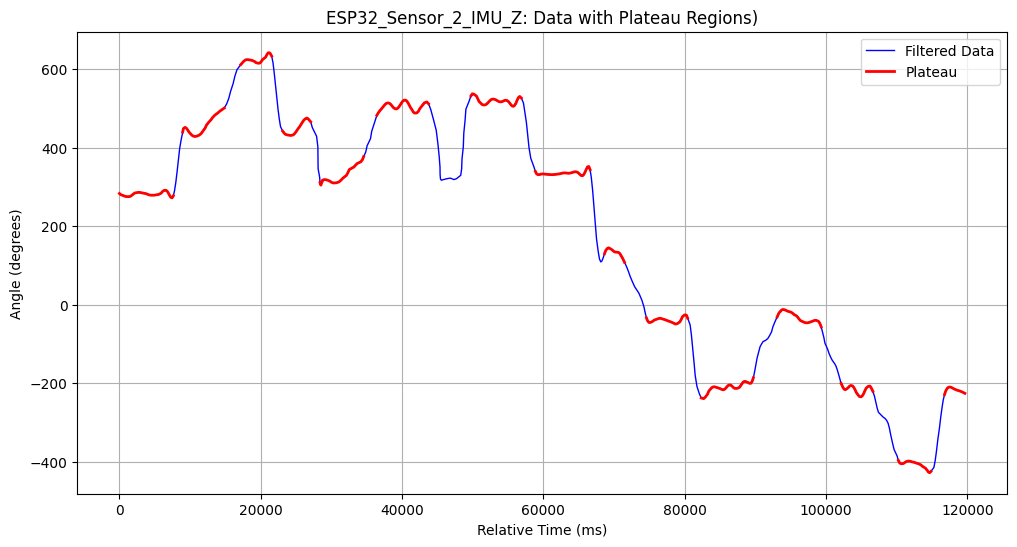

Processed Mamyr_2 successfully.
Processing NewSavedData\Mamyr_3\2025-07-03T11_13_52.cfg...

Successfully extracted data:


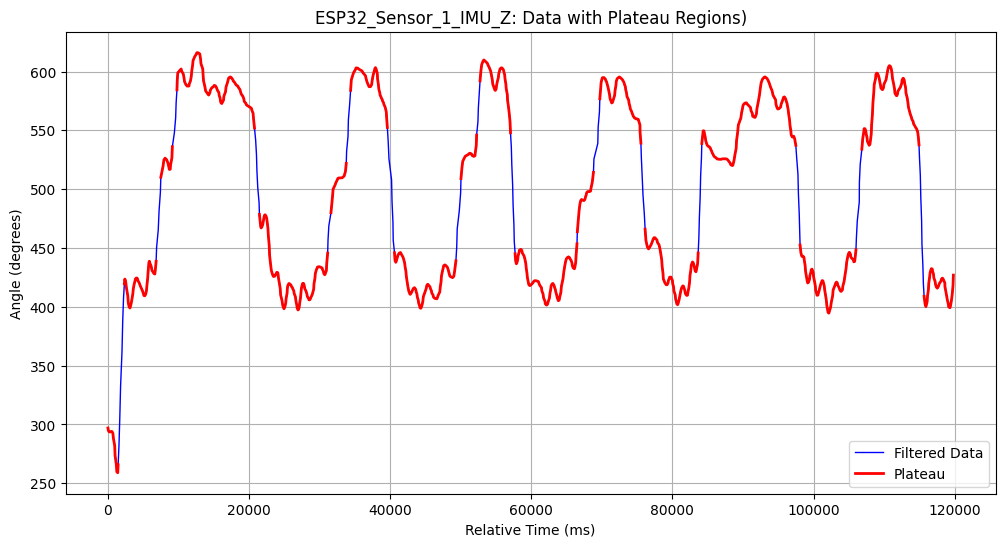

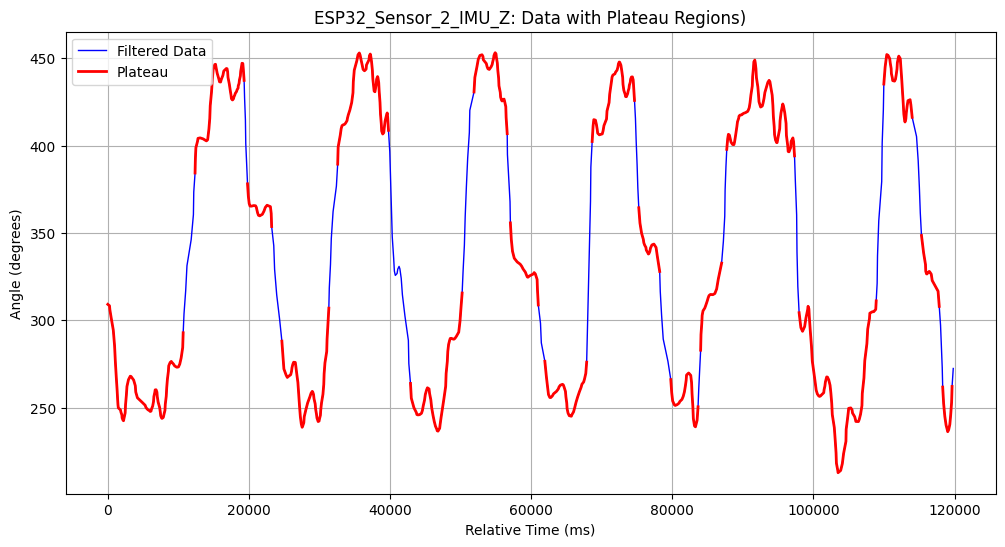

Processed Mamyr_3 successfully.
Processing NewSavedData\Mamyr_4\2025-07-03T11_17_51.cfg...

Successfully extracted data:


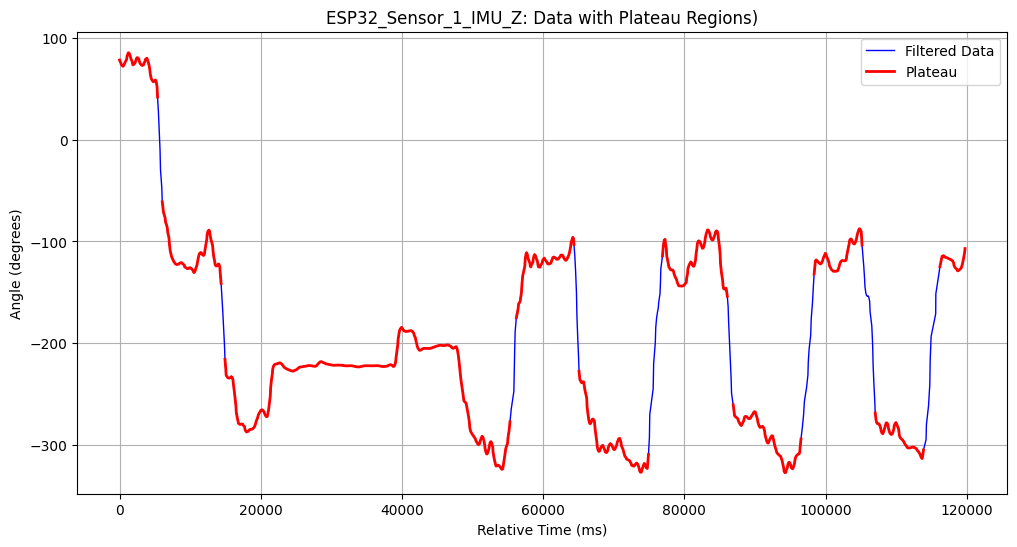

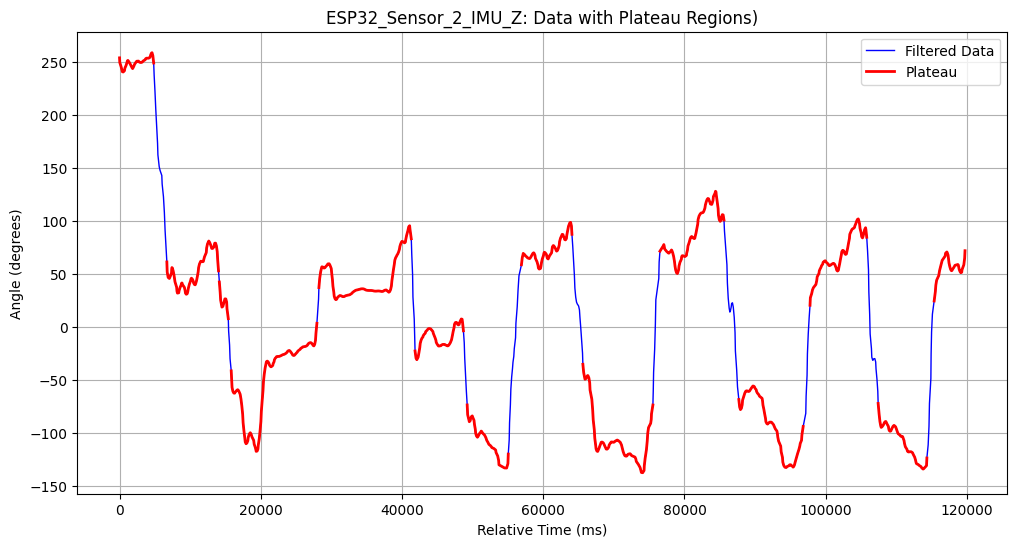

Processed Mamyr_4 successfully.
Processing NewSavedData\Mamyr_5\2025-07-03T11_27_23.cfg...

Successfully extracted data:


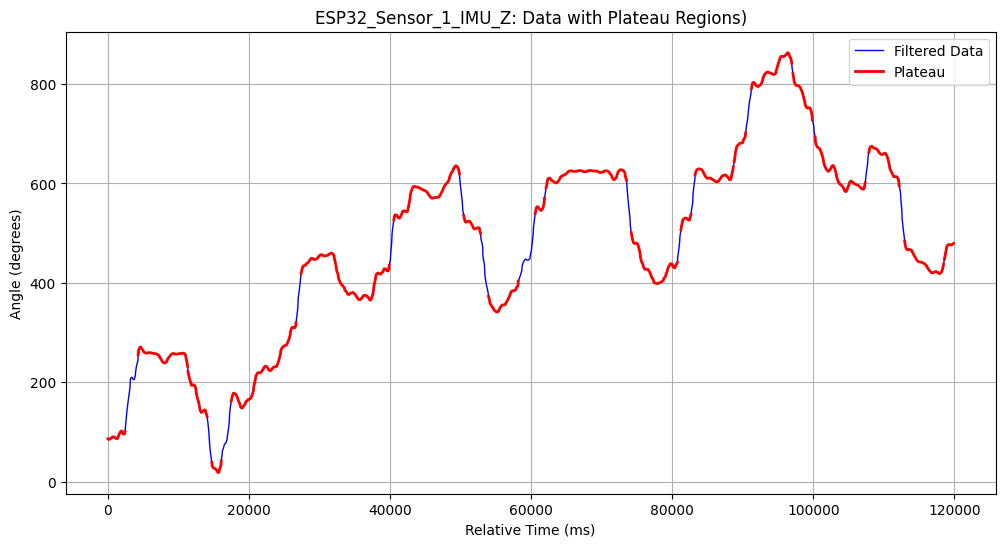

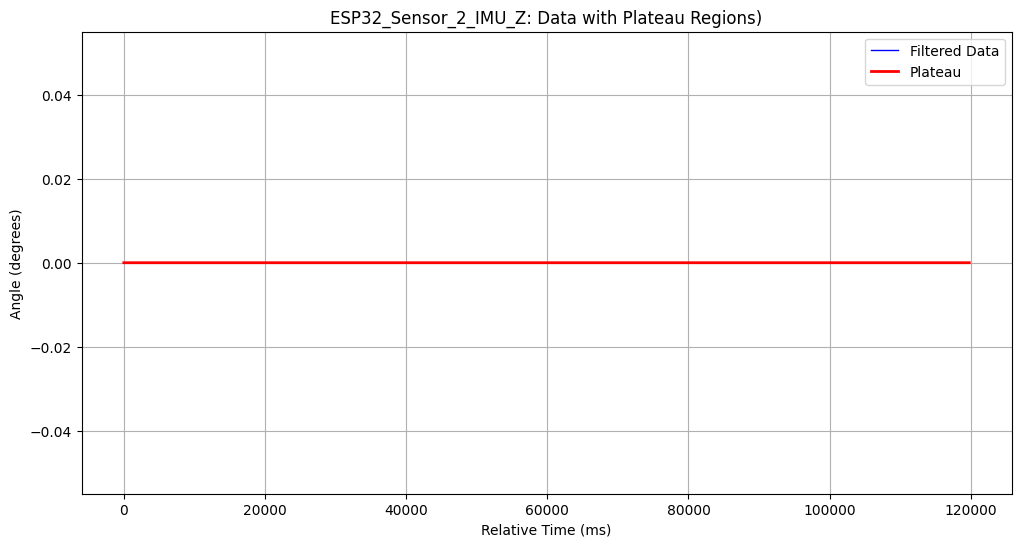

Processed Mamyr_5 successfully.
Processing NewSavedData\Mamyr_6\2025-07-03T11_36_43.cfg...

Successfully extracted data:


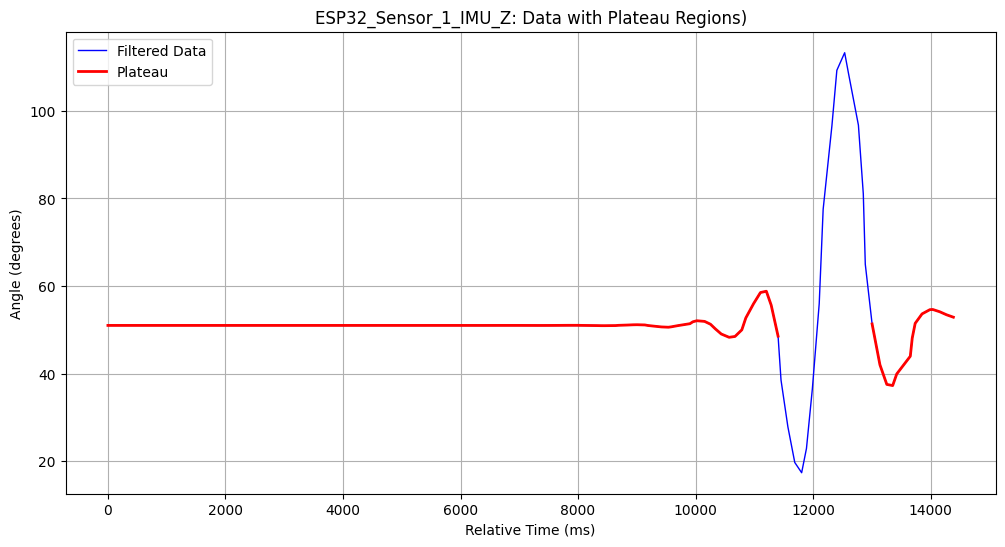

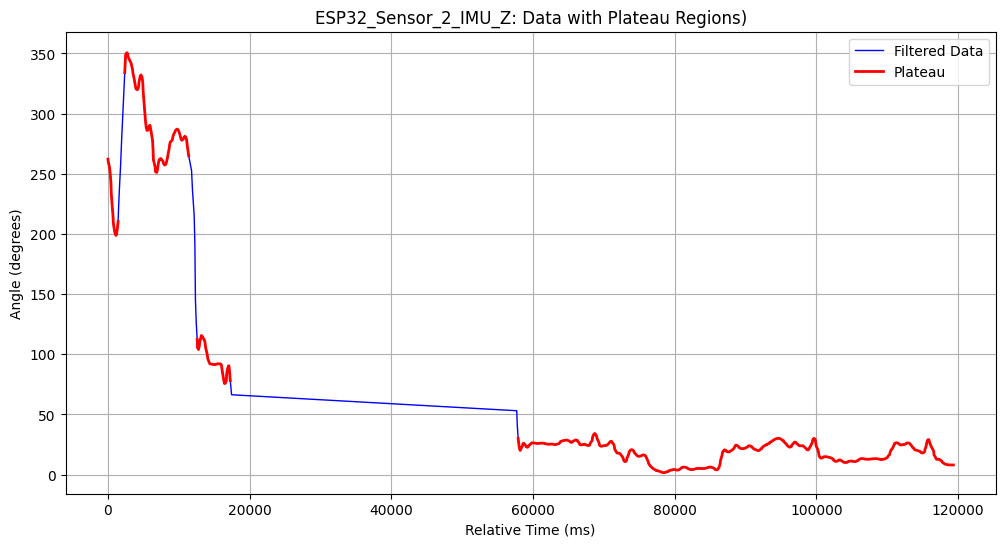

Processing NewSavedData\Mamyr_6\2025-07-03T11_40_19.cfg...

Successfully extracted data:


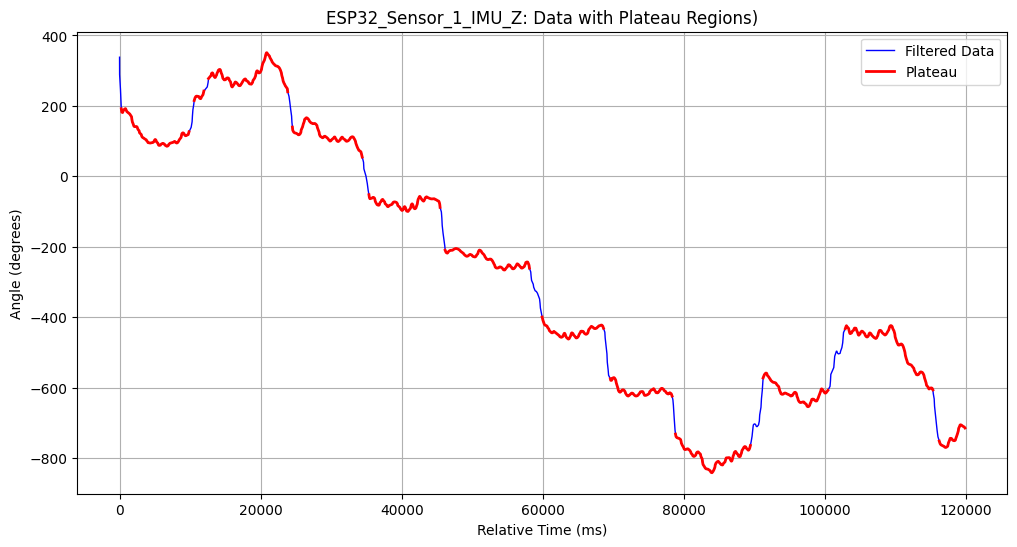

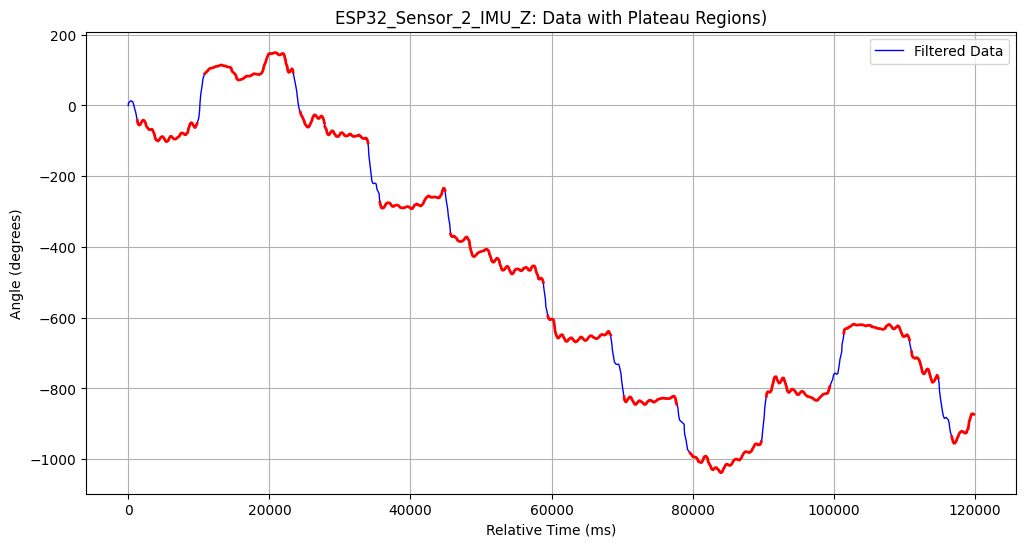

Processed Mamyr_6 successfully.
Processing NewSavedData\Mamyr_7\2025-07-03T11_44_30.cfg...

Successfully extracted data:


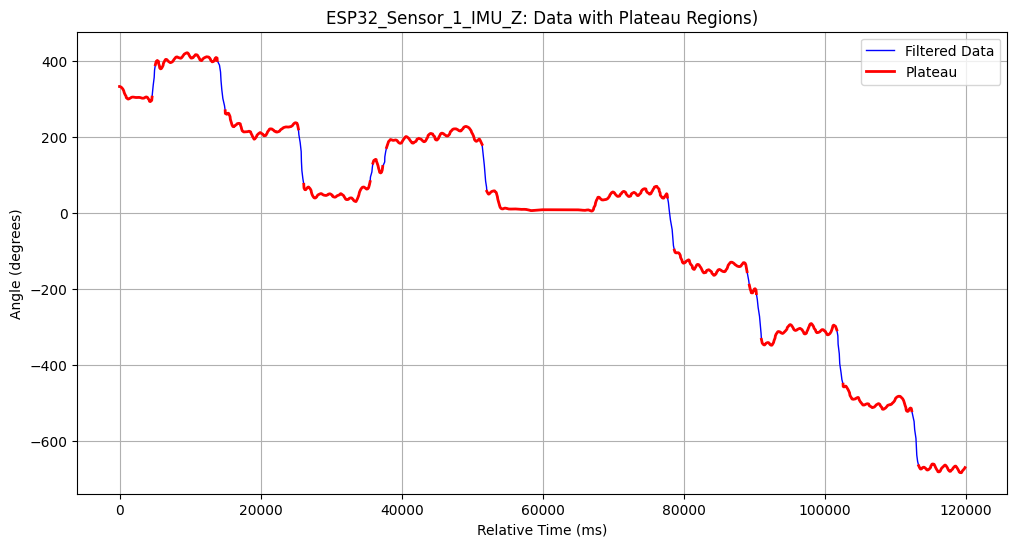

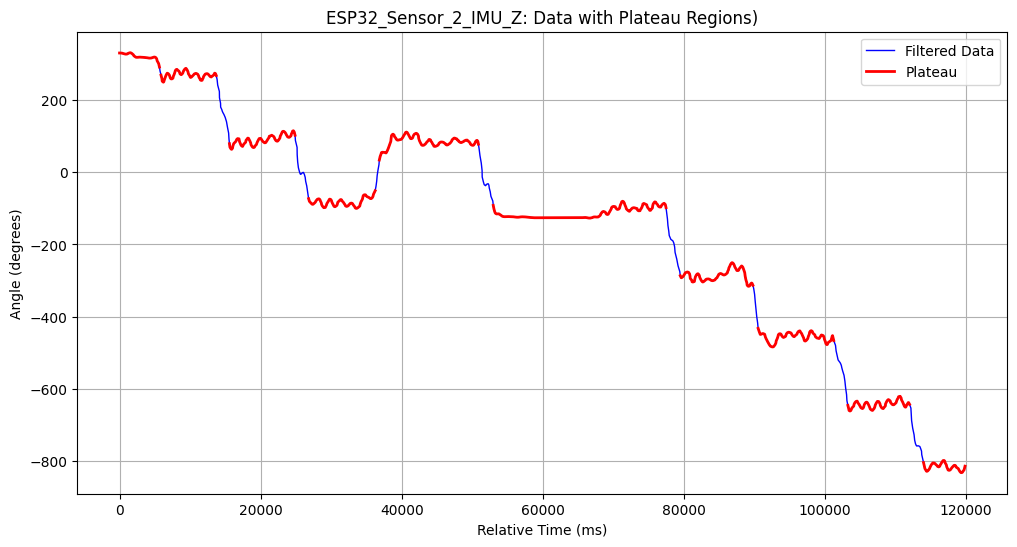

Processed Mamyr_7 successfully.
Processing NewSavedData\Mamyr_8\2025-07-03T11_53_26.cfg...

Successfully extracted data:


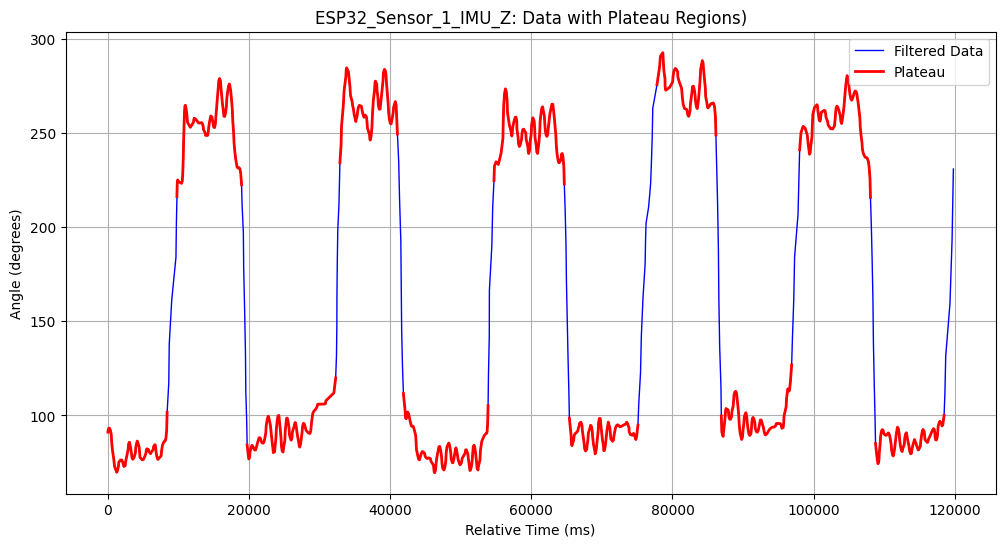

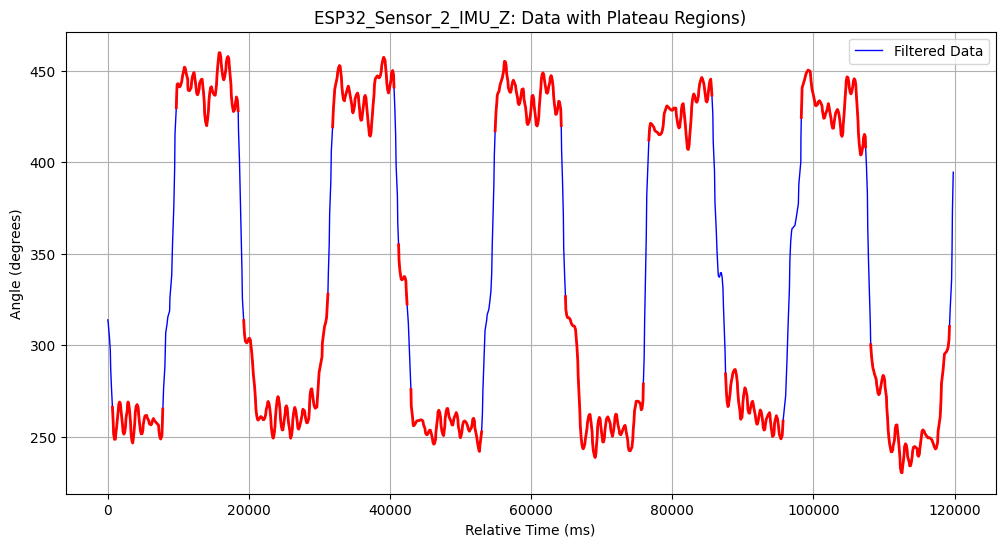

Processed Mamyr_8 successfully.
Processing NewSavedData\Mamyr_9\2025-07-03T11_58_14.cfg...

Successfully extracted data:


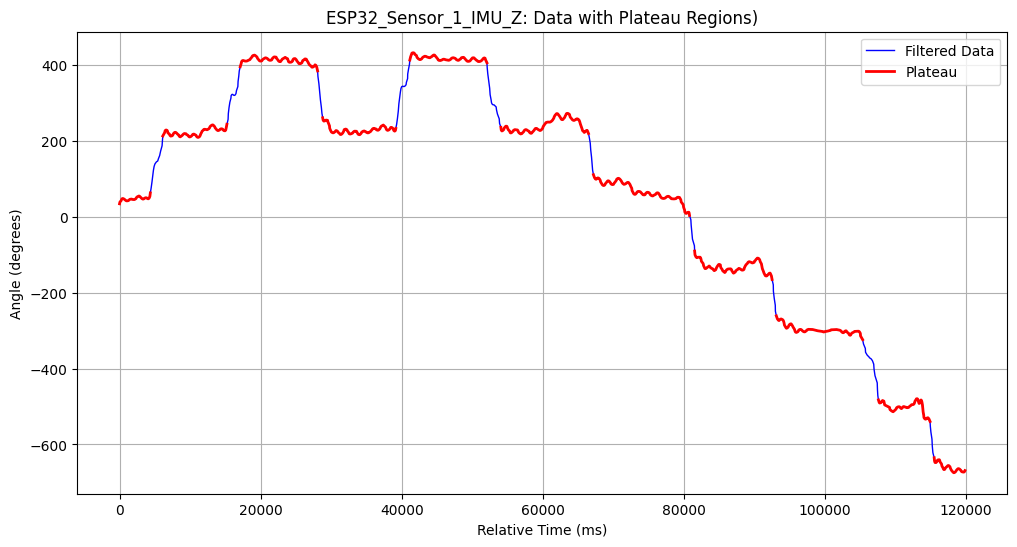

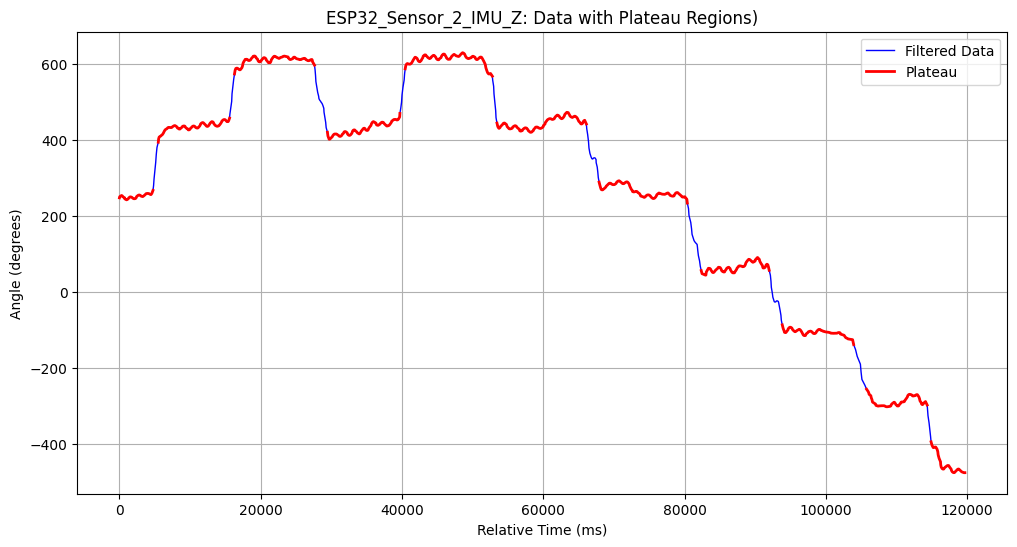

Processed Mamyr_9 successfully.
Processing NewSavedData\Mamyr_10\2025-07-03T12_03_58.cfg...

Successfully extracted data:


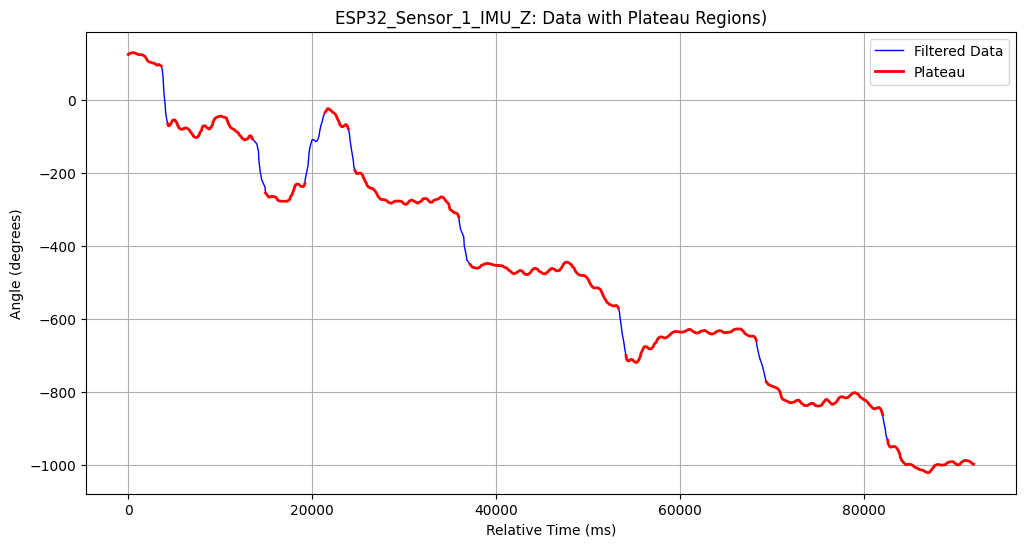

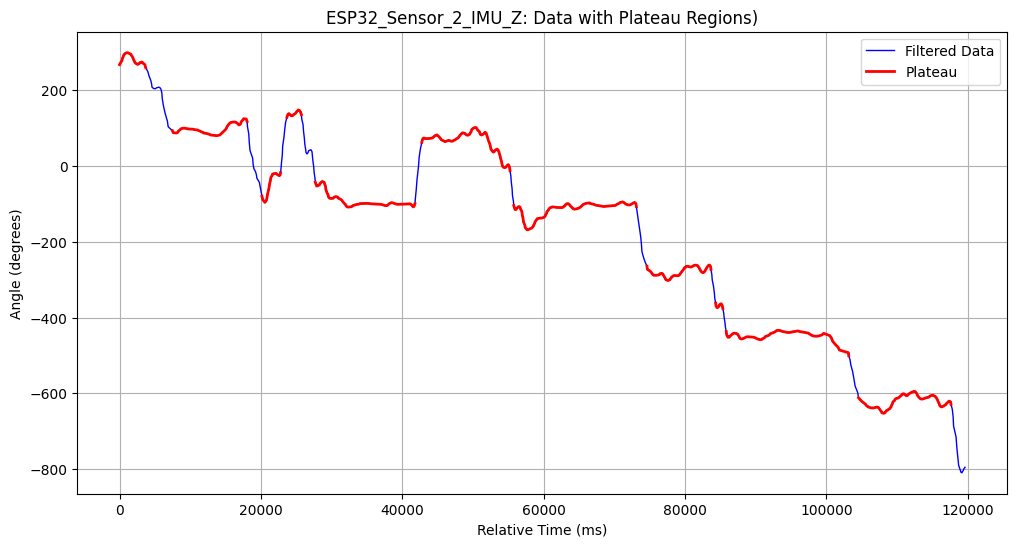

Processed Mamyr_10 successfully.
Processing NewSavedData\Mamyr_11\2025-07-03T10_49_44.cfg...

Successfully extracted data:


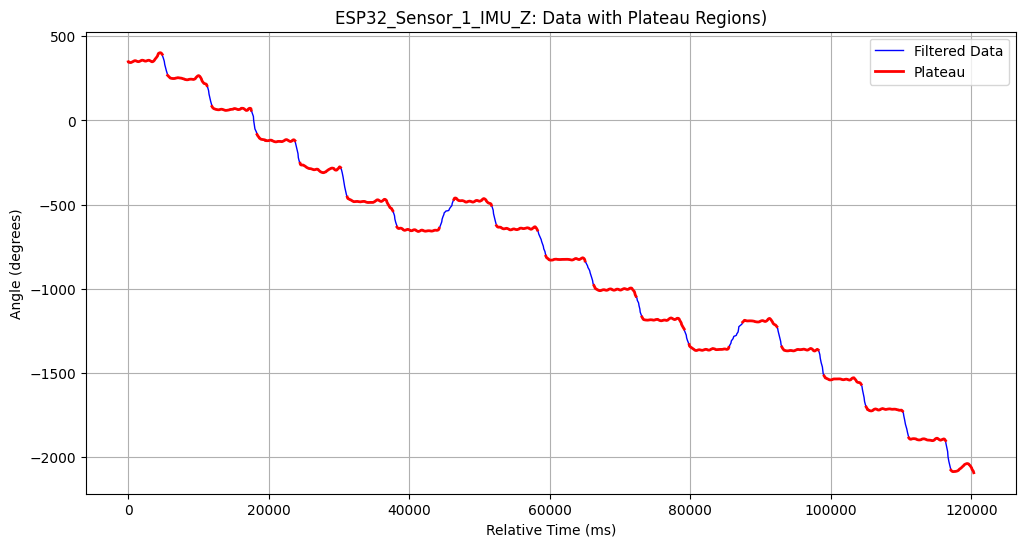

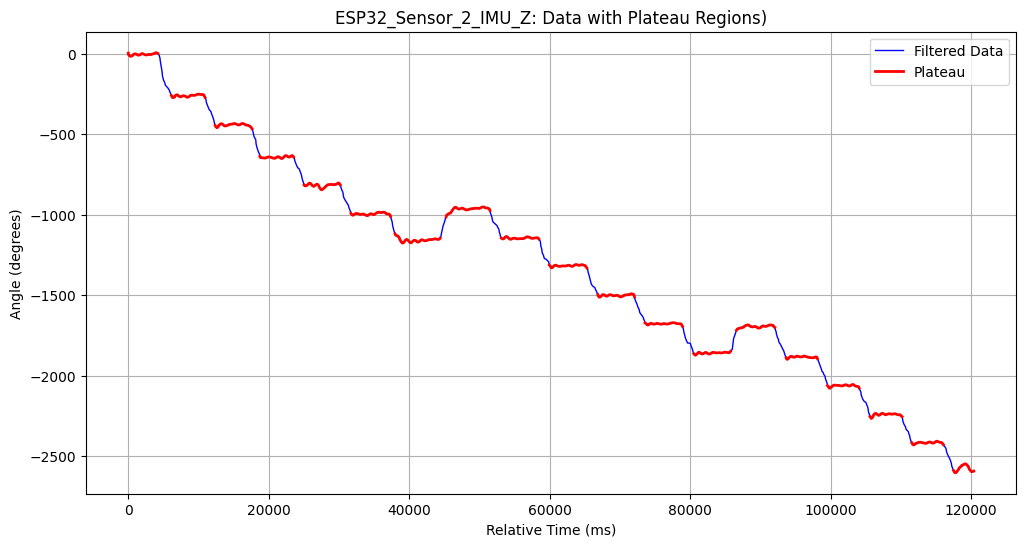

Processing NewSavedData\Mamyr_11\2025-07-03T10_57_37.cfg...

Successfully extracted data:


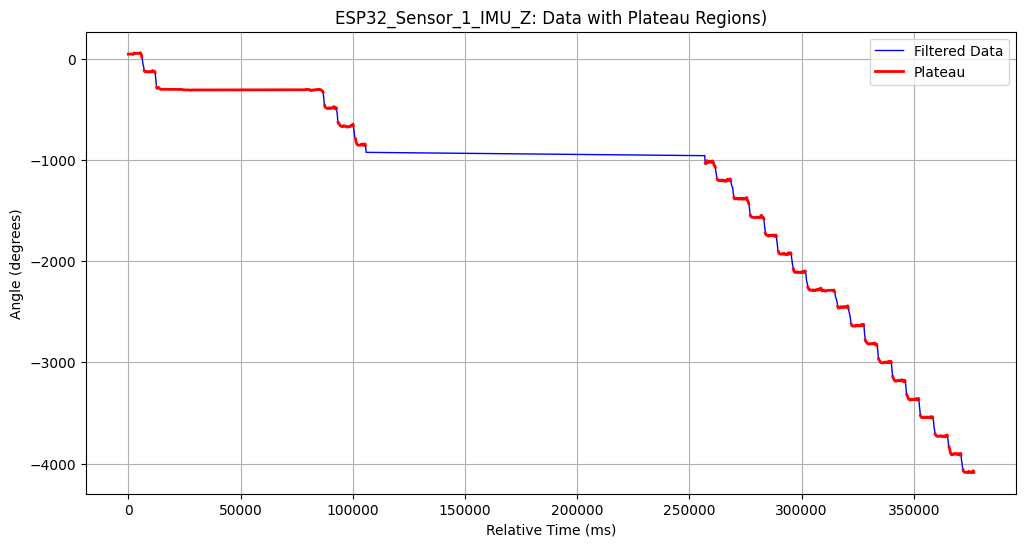

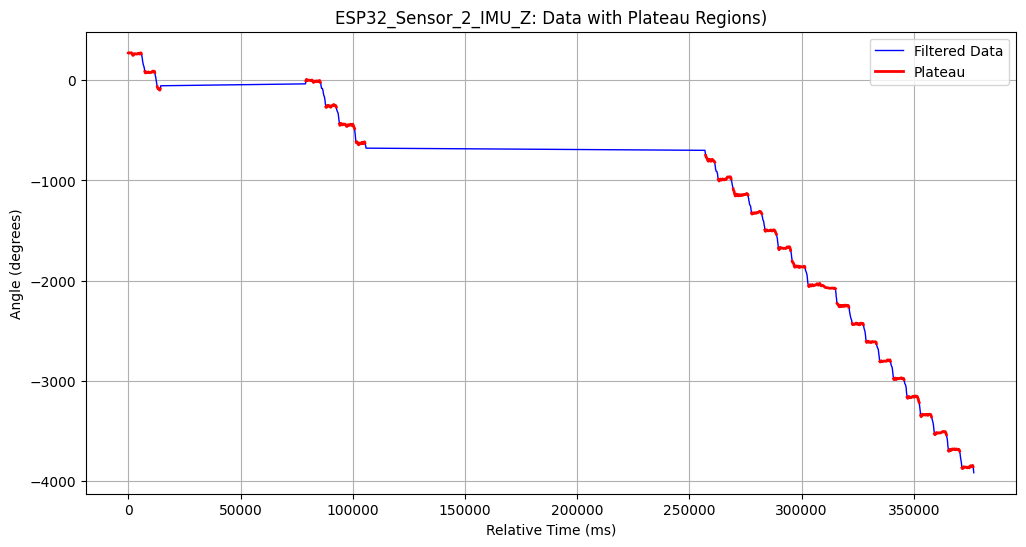

Processed Mamyr_11 successfully.
Processing NewSavedData\Prothesis_1\2025-07-03T14_42_44.cfg...

Successfully extracted data:


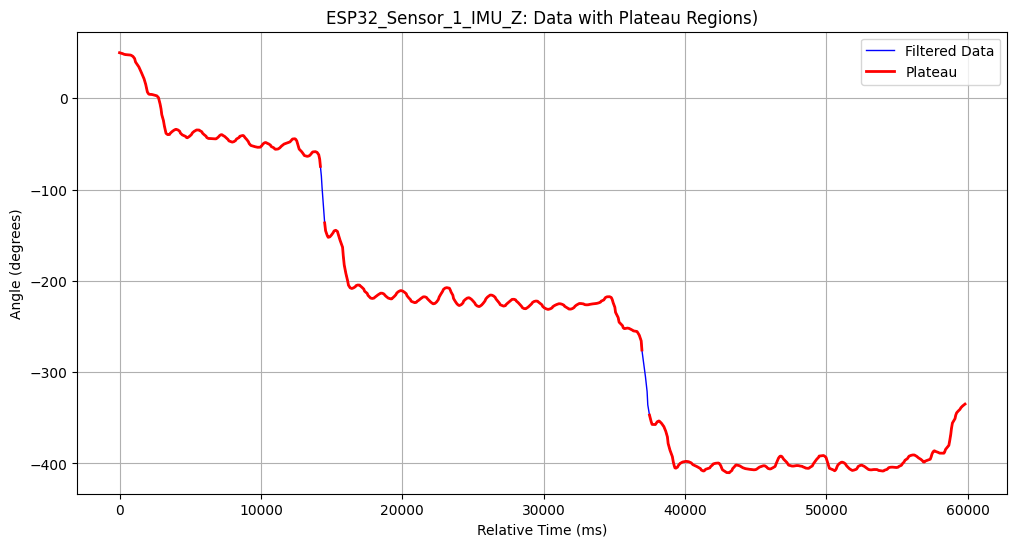

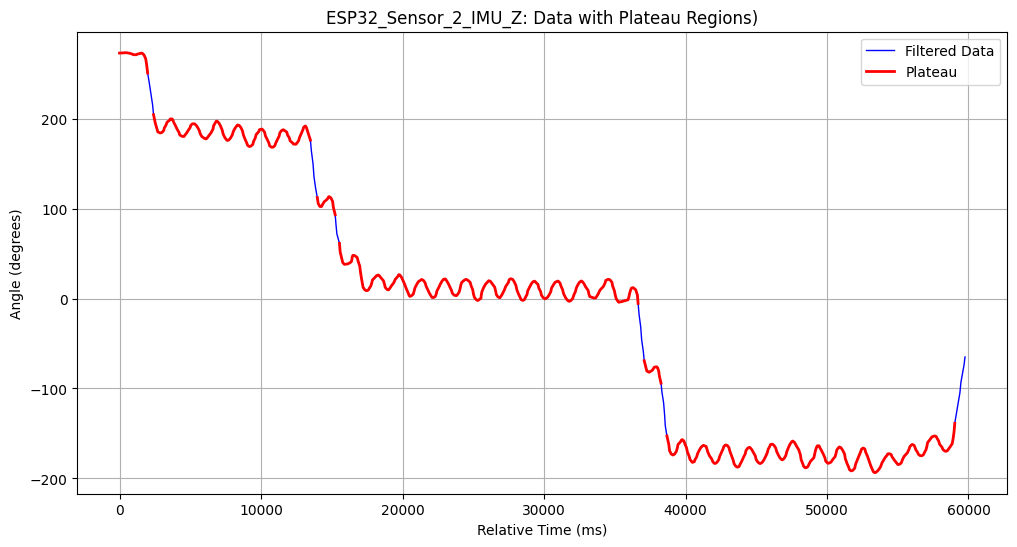

Processed Prothesis_1 successfully.
Processing NewSavedData\Roman_Olimp_Chemp\2025-07-07T13_16_33.cfg...

Successfully extracted data:


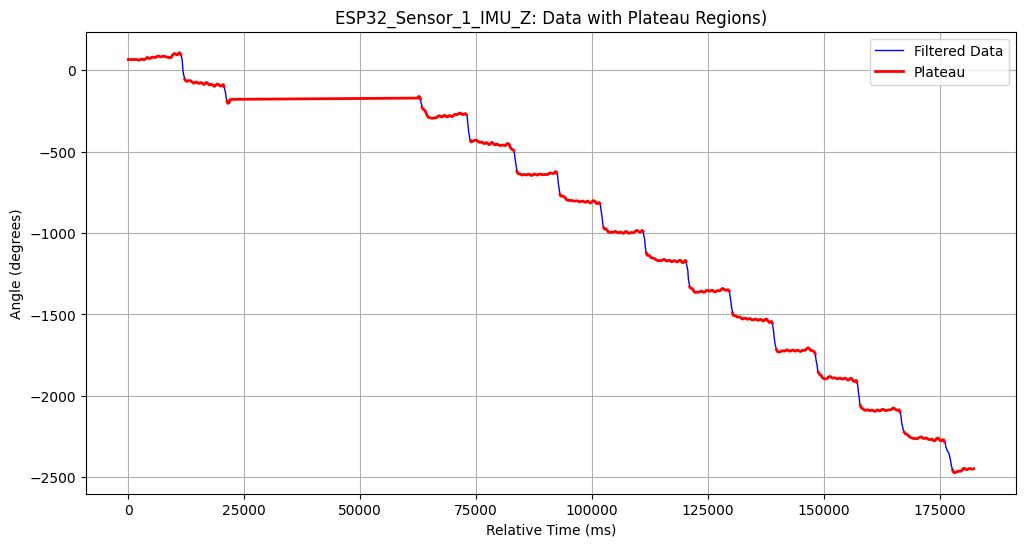

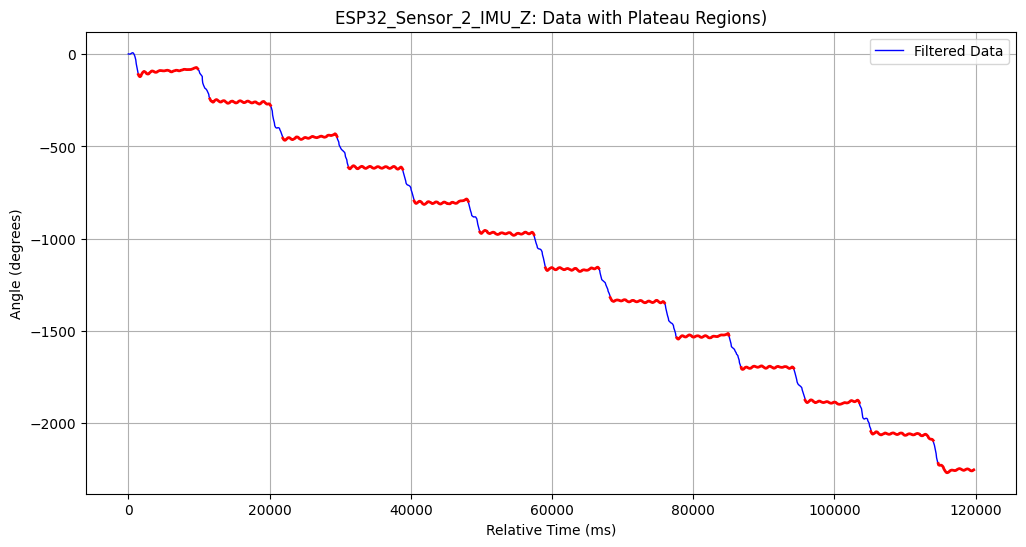

Processed Roman_Olimp_Chemp successfully.


In [54]:
for i in patients:
    convert_to_pickle(i)
    print(f"Processed {i} successfully.")